In [1]:
# import sys 
# sys.path
# sys.path.append("~/anaconda3/lib/python3.8/site-packages/tensorflow_estimator")
# sys.path
# import tensorflow as tfimport numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from sklearn.metrics import accuracy_score
from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import keras
import tensorflow as tf
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1,2'

Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 64
        self.data_dir = '/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/data/SHREC/'
C = Config()

# Building the model

In [4]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W]) 
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=64):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)


    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])

    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [5]:
def build_DD_Net(frame_l=32,joint_n=22,joint_d=3,feat_d=231,clc_num=28,filters=64):
    M = Input(name='M', shape=(frame_l,feat_d))  
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) 
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)

    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)

    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [6]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_fine,C.filters)

In [7]:
DD_Net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 231)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 22, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 512)       1740160     M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           model_1[1][0]              

In [8]:
#DD_Net.load_weights('weights/fine_heavy.h5')

## load data

In [9]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

## Without frame_sampling train

In [10]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])#[:,C.joint_ind,:]
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_fine)
    label[Train['fine_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 117.01it/s]


In [11]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])#[:,C.joint_ind,:]
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_fine)
    label[Test['fine_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|████████████████████████████████████████| 840/840 [00:07<00:00, 119.40it/s]


In [12]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)
history = DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=700,
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/700
1960/1960 [==============================] - 7s 4ms/step - loss: 4.1470 - accuracy: 0.0291 - val_loss: 3.3319 - val_accuracy: 0.0488
Epoch 2/700
1960/1960 [==============================] - 0s 142us/step - loss: 3.7323 - accuracy: 0.0577 - val_loss: 3.3319 - val_accuracy: 0.0333
Epoch 3/700
1960/1960 [==============================] - 0s 134us/step - loss: 3.5171 - accuracy: 0.0811 - val_loss: 3.3323 - val_accuracy: 0.0333
Epoch 4/700
1960/1960 [==============================] - 0s 127us/step - loss: 3.3002 - accuracy: 0.1041 - val_loss: 3.3327 - val_accuracy: 0.0286
Epoch 5/700
1960/1960 [==============================] - 0s 138us/step - loss: 3.1914 - accuracy: 0.1066 - val_loss: 3.3333 - val_accuracy: 0.0286
Epoch 6/700
1960/1960 [==============================] - 0s 129us/step - loss: 3.0946 - accuracy: 0.1321 - val_loss: 3.3338 - val_accuracy: 0.0286
Epoch 7/700
1960/1960 [==============================] - 0s 136us/step - 

Epoch 57/700
1960/1960 [==============================] - 0s 143us/step - loss: 0.4729 - accuracy: 0.9107 - val_loss: 3.9628 - val_accuracy: 0.0595
Epoch 58/700
1960/1960 [==============================] - 0s 133us/step - loss: 0.4515 - accuracy: 0.9194 - val_loss: 3.9636 - val_accuracy: 0.0655
Epoch 59/700
1960/1960 [==============================] - 0s 143us/step - loss: 0.4304 - accuracy: 0.9204 - val_loss: 3.9987 - val_accuracy: 0.0667
Epoch 60/700
1960/1960 [==============================] - 0s 134us/step - loss: 0.4348 - accuracy: 0.9128 - val_loss: 4.0508 - val_accuracy: 0.0726
Epoch 61/700
1960/1960 [==============================] - 0s 145us/step - loss: 0.4313 - accuracy: 0.9209 - val_loss: 4.0964 - val_accuracy: 0.0738
Epoch 62/700
1960/1960 [==============================] - 0s 136us/step - loss: 0.4238 - accuracy: 0.9194 - val_loss: 4.1403 - val_accuracy: 0.0726
Epoch 63/700
1960/1960 [==============================] - 0s 142us/step - loss: 0.4009 - accuracy: 0.9321 - val_

Epoch 113/700
1960/1960 [==============================] - 0s 137us/step - loss: 0.1216 - accuracy: 0.9857 - val_loss: 5.3925 - val_accuracy: 0.0345
Epoch 114/700
1960/1960 [==============================] - 0s 133us/step - loss: 0.1298 - accuracy: 0.9842 - val_loss: 5.4023 - val_accuracy: 0.0357
Epoch 115/700
1960/1960 [==============================] - 0s 139us/step - loss: 0.1266 - accuracy: 0.9888 - val_loss: 5.3903 - val_accuracy: 0.0369
Epoch 116/700
1960/1960 [==============================] - 0s 134us/step - loss: 0.1333 - accuracy: 0.9832 - val_loss: 5.3608 - val_accuracy: 0.0417
Epoch 117/700
1960/1960 [==============================] - 0s 143us/step - loss: 0.1213 - accuracy: 0.9888 - val_loss: 5.2869 - val_accuracy: 0.0464
Epoch 118/700
1960/1960 [==============================] - 0s 137us/step - loss: 0.1173 - accuracy: 0.9893 - val_loss: 5.2194 - val_accuracy: 0.0512
Epoch 119/700
1960/1960 [==============================] - 0s 144us/step - loss: 0.1154 - accuracy: 0.9847

Epoch 168/700
1960/1960 [==============================] - 0s 140us/step - loss: 0.0608 - accuracy: 0.9954 - val_loss: 5.9280 - val_accuracy: 0.0488
Epoch 169/700
1960/1960 [==============================] - 0s 148us/step - loss: 0.0637 - accuracy: 0.9934 - val_loss: 5.9099 - val_accuracy: 0.0488
Epoch 170/700
1960/1960 [==============================] - 0s 134us/step - loss: 0.0629 - accuracy: 0.9959 - val_loss: 5.9232 - val_accuracy: 0.0476
Epoch 171/700
1960/1960 [==============================] - 0s 140us/step - loss: 0.0666 - accuracy: 0.9929 - val_loss: 5.9492 - val_accuracy: 0.0464
Epoch 172/700
1960/1960 [==============================] - 0s 130us/step - loss: 0.0548 - accuracy: 0.9985 - val_loss: 5.9888 - val_accuracy: 0.0452
Epoch 173/700
1960/1960 [==============================] - 0s 140us/step - loss: 0.0613 - accuracy: 0.9949 - val_loss: 5.9965 - val_accuracy: 0.0452
Epoch 174/700
1960/1960 [==============================] - 0s 134us/step - loss: 0.0638 - accuracy: 0.9934

Epoch 223/700
1960/1960 [==============================] - 0s 136us/step - loss: 0.0507 - accuracy: 0.9969 - val_loss: 5.9397 - val_accuracy: 0.0560
Epoch 224/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0557 - accuracy: 0.9954 - val_loss: 5.9371 - val_accuracy: 0.0560
Epoch 225/700
1960/1960 [==============================] - 0s 139us/step - loss: 0.0545 - accuracy: 0.9954 - val_loss: 5.9348 - val_accuracy: 0.0560
Epoch 226/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0581 - accuracy: 0.9954 - val_loss: 5.9326 - val_accuracy: 0.0560
Epoch 227/700
1960/1960 [==============================] - 0s 140us/step - loss: 0.0507 - accuracy: 0.9985 - val_loss: 5.9299 - val_accuracy: 0.0560
Epoch 228/700
1960/1960 [==============================] - 0s 133us/step - loss: 0.0529 - accuracy: 0.9954 - val_loss: 5.9263 - val_accuracy: 0.0560
Epoch 229/700
1960/1960 [==============================] - 0s 138us/step - loss: 0.0534 - accuracy: 0.9954

Epoch 278/700
1960/1960 [==============================] - 0s 127us/step - loss: 0.0514 - accuracy: 0.9969 - val_loss: 5.3896 - val_accuracy: 0.0821
Epoch 279/700
1960/1960 [==============================] - 0s 138us/step - loss: 0.0557 - accuracy: 0.9949 - val_loss: 5.3749 - val_accuracy: 0.0833
Epoch 280/700
1960/1960 [==============================] - 0s 134us/step - loss: 0.0505 - accuracy: 0.9954 - val_loss: 5.3596 - val_accuracy: 0.0857
Epoch 281/700
1960/1960 [==============================] - 0s 142us/step - loss: 0.0508 - accuracy: 0.9964 - val_loss: 5.3435 - val_accuracy: 0.0857
Epoch 282/700
1960/1960 [==============================] - 0s 133us/step - loss: 0.0516 - accuracy: 0.9980 - val_loss: 5.3275 - val_accuracy: 0.0857
Epoch 283/700
1960/1960 [==============================] - 0s 141us/step - loss: 0.0518 - accuracy: 0.9980 - val_loss: 5.3113 - val_accuracy: 0.0869
Epoch 284/700
1960/1960 [==============================] - 0s 135us/step - loss: 0.0481 - accuracy: 0.9985

Epoch 333/700
1960/1960 [==============================] - 0s 148us/step - loss: 0.0455 - accuracy: 0.9969 - val_loss: 4.2483 - val_accuracy: 0.1702
Epoch 334/700
1960/1960 [==============================] - 0s 136us/step - loss: 0.0535 - accuracy: 0.9939 - val_loss: 4.2233 - val_accuracy: 0.1726
Epoch 335/700
1960/1960 [==============================] - 0s 139us/step - loss: 0.0539 - accuracy: 0.9944 - val_loss: 4.1984 - val_accuracy: 0.1762
Epoch 336/700
1960/1960 [==============================] - 0s 134us/step - loss: 0.0503 - accuracy: 0.9974 - val_loss: 4.1721 - val_accuracy: 0.1798
Epoch 337/700
1960/1960 [==============================] - 0s 145us/step - loss: 0.0587 - accuracy: 0.9923 - val_loss: 4.1468 - val_accuracy: 0.1857
Epoch 338/700
1960/1960 [==============================] - 0s 141us/step - loss: 0.0510 - accuracy: 0.9969 - val_loss: 4.1211 - val_accuracy: 0.1869
Epoch 339/700
1960/1960 [==============================] - 0s 154us/step - loss: 0.0534 - accuracy: 0.9959

Epoch 388/700
1960/1960 [==============================] - 0s 137us/step - loss: 0.0499 - accuracy: 0.9959 - val_loss: 2.8026 - val_accuracy: 0.3667
Epoch 389/700
1960/1960 [==============================] - 0s 142us/step - loss: 0.0524 - accuracy: 0.9964 - val_loss: 2.7782 - val_accuracy: 0.3702
Epoch 390/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0502 - accuracy: 0.9964 - val_loss: 2.7536 - val_accuracy: 0.3714
Epoch 391/700
1960/1960 [==============================] - 0s 140us/step - loss: 0.0506 - accuracy: 0.9980 - val_loss: 2.7278 - val_accuracy: 0.3786
Epoch 392/700
1960/1960 [==============================] - 0s 134us/step - loss: 0.0537 - accuracy: 0.9929 - val_loss: 2.7020 - val_accuracy: 0.3798
Epoch 393/700
1960/1960 [==============================] - 0s 135us/step - loss: 0.0499 - accuracy: 0.9959 - val_loss: 2.6766 - val_accuracy: 0.3821
Epoch 394/700
1960/1960 [==============================] - 0s 131us/step - loss: 0.0467 - accuracy: 0.9954

Epoch 443/700
1960/1960 [==============================] - 0s 143us/step - loss: 0.0502 - accuracy: 0.9974 - val_loss: 1.6096 - val_accuracy: 0.6131
Epoch 444/700
1960/1960 [==============================] - 0s 134us/step - loss: 0.0480 - accuracy: 0.9964 - val_loss: 1.5928 - val_accuracy: 0.6167
Epoch 445/700
1960/1960 [==============================] - 0s 141us/step - loss: 0.0527 - accuracy: 0.9964 - val_loss: 1.5755 - val_accuracy: 0.6190
Epoch 446/700
1960/1960 [==============================] - 0s 134us/step - loss: 0.0538 - accuracy: 0.9944 - val_loss: 1.5584 - val_accuracy: 0.6262
Epoch 447/700
1960/1960 [==============================] - 0s 140us/step - loss: 0.0485 - accuracy: 0.9974 - val_loss: 1.5413 - val_accuracy: 0.6310
Epoch 448/700
1960/1960 [==============================] - 0s 133us/step - loss: 0.0479 - accuracy: 0.9969 - val_loss: 1.5242 - val_accuracy: 0.6345
Epoch 449/700
1960/1960 [==============================] - 0s 140us/step - loss: 0.0498 - accuracy: 0.9944

Epoch 498/700
1960/1960 [==============================] - 0s 139us/step - loss: 0.0479 - accuracy: 0.9974 - val_loss: 0.9021 - val_accuracy: 0.7702
Epoch 499/700
1960/1960 [==============================] - 0s 144us/step - loss: 0.0465 - accuracy: 0.9954 - val_loss: 0.8934 - val_accuracy: 0.7726
Epoch 500/700
1960/1960 [==============================] - 0s 135us/step - loss: 0.0444 - accuracy: 0.9980 - val_loss: 0.8847 - val_accuracy: 0.7762
Epoch 501/700
1960/1960 [==============================] - 0s 151us/step - loss: 0.0510 - accuracy: 0.9974 - val_loss: 0.8760 - val_accuracy: 0.7774
Epoch 502/700
1960/1960 [==============================] - 0s 136us/step - loss: 0.0483 - accuracy: 0.9964 - val_loss: 0.8677 - val_accuracy: 0.7810
Epoch 503/700
1960/1960 [==============================] - 0s 146us/step - loss: 0.0447 - accuracy: 0.9964 - val_loss: 0.8595 - val_accuracy: 0.7810
Epoch 504/700
1960/1960 [==============================] - 0s 136us/step - loss: 0.0468 - accuracy: 0.9964

Epoch 553/700
1960/1960 [==============================] - 0s 155us/step - loss: 0.0493 - accuracy: 0.9964 - val_loss: 0.5672 - val_accuracy: 0.8500
Epoch 554/700
1960/1960 [==============================] - 0s 144us/step - loss: 0.0478 - accuracy: 0.9974 - val_loss: 0.5634 - val_accuracy: 0.8512
Epoch 555/700
1960/1960 [==============================] - 0s 145us/step - loss: 0.0489 - accuracy: 0.9974 - val_loss: 0.5596 - val_accuracy: 0.8512
Epoch 556/700
1960/1960 [==============================] - 0s 135us/step - loss: 0.0487 - accuracy: 0.9980 - val_loss: 0.5557 - val_accuracy: 0.8524
Epoch 557/700
1960/1960 [==============================] - 0s 143us/step - loss: 0.0443 - accuracy: 0.9985 - val_loss: 0.5518 - val_accuracy: 0.8548
Epoch 558/700
1960/1960 [==============================] - 0s 135us/step - loss: 0.0472 - accuracy: 0.9969 - val_loss: 0.5480 - val_accuracy: 0.8548
Epoch 559/700
1960/1960 [==============================] - 0s 138us/step - loss: 0.0427 - accuracy: 0.9985

Epoch 608/700
1960/1960 [==============================] - 0s 139us/step - loss: 0.0465 - accuracy: 0.9974 - val_loss: 0.4257 - val_accuracy: 0.8952
Epoch 609/700
1960/1960 [==============================] - 0s 146us/step - loss: 0.0478 - accuracy: 0.9980 - val_loss: 0.4240 - val_accuracy: 0.8952
Epoch 610/700
1960/1960 [==============================] - 0s 138us/step - loss: 0.0457 - accuracy: 0.9969 - val_loss: 0.4222 - val_accuracy: 0.8952
Epoch 611/700
1960/1960 [==============================] - 0s 144us/step - loss: 0.0475 - accuracy: 0.9974 - val_loss: 0.4205 - val_accuracy: 0.8964
Epoch 612/700
1960/1960 [==============================] - 0s 137us/step - loss: 0.0436 - accuracy: 0.9990 - val_loss: 0.4188 - val_accuracy: 0.8964
Epoch 613/700
1960/1960 [==============================] - 0s 146us/step - loss: 0.0459 - accuracy: 0.9974 - val_loss: 0.4171 - val_accuracy: 0.8964
Epoch 614/700
1960/1960 [==============================] - 0s 132us/step - loss: 0.0483 - accuracy: 0.9974

Epoch 663/700
1960/1960 [==============================] - 0s 143us/step - loss: 0.0463 - accuracy: 0.9969 - val_loss: 0.3629 - val_accuracy: 0.9119
Epoch 664/700
1960/1960 [==============================] - 0s 135us/step - loss: 0.0501 - accuracy: 0.9959 - val_loss: 0.3620 - val_accuracy: 0.9119
Epoch 665/700
1960/1960 [==============================] - 0s 143us/step - loss: 0.0494 - accuracy: 0.9954 - val_loss: 0.3613 - val_accuracy: 0.9119
Epoch 666/700
1960/1960 [==============================] - 0s 134us/step - loss: 0.0488 - accuracy: 0.9954 - val_loss: 0.3607 - val_accuracy: 0.9119
Epoch 667/700
1960/1960 [==============================] - 0s 144us/step - loss: 0.0444 - accuracy: 0.9969 - val_loss: 0.3600 - val_accuracy: 0.9119
Epoch 668/700
1960/1960 [==============================] - 0s 134us/step - loss: 0.0537 - accuracy: 0.9954 - val_loss: 0.3594 - val_accuracy: 0.9119
Epoch 669/700
1960/1960 [==============================] - 0s 140us/step - loss: 0.0465 - accuracy: 0.9964

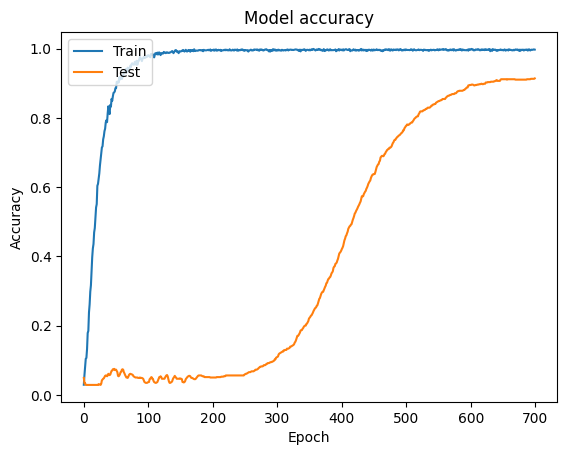

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
DD_Net.save_weights('weights/fine_heavy.h5')

In [15]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [16]:
labels = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [17]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9142857142857143


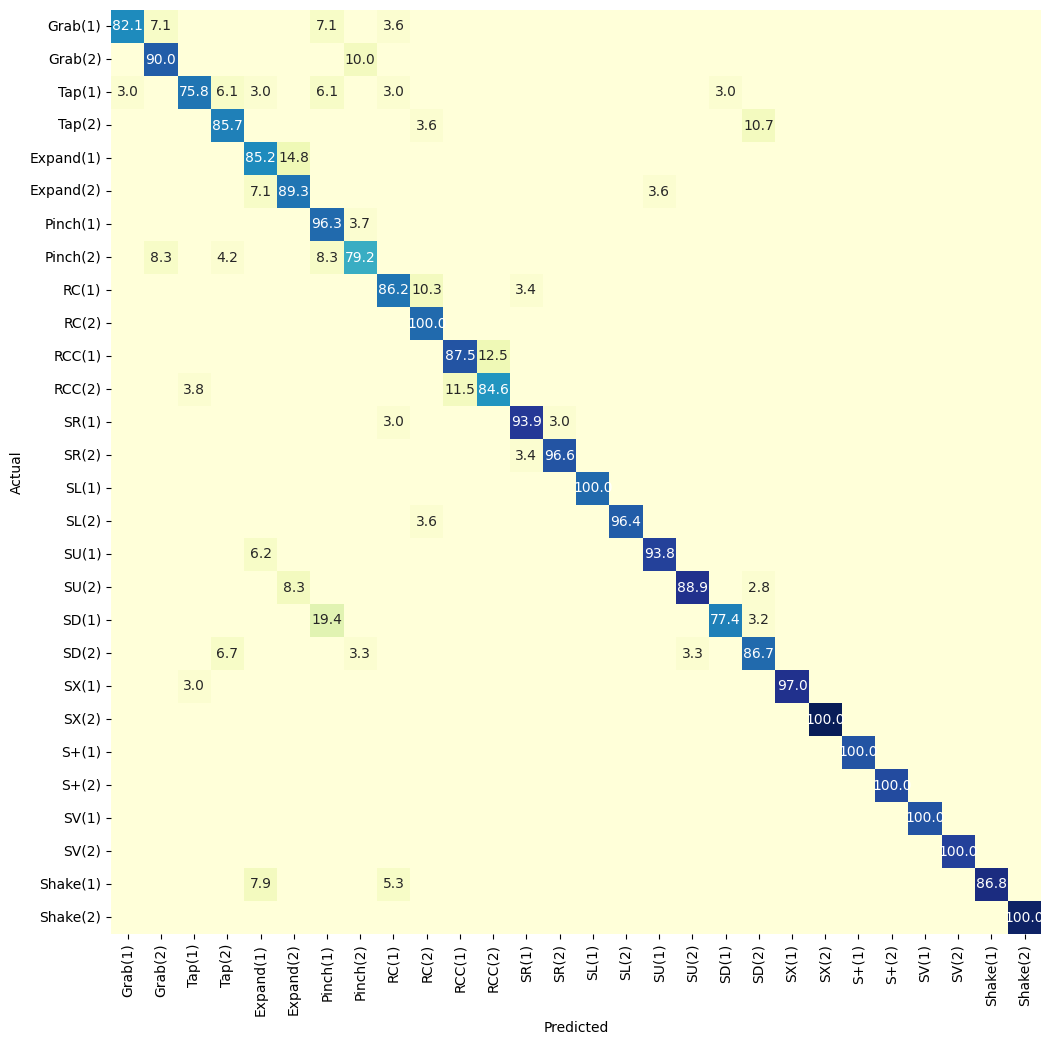

In [18]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_28_1.png', labels, ymap=None, figsize=(12,12))

## Training with frame_sampling

In [19]:
lr = 1e-5
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])

In [20]:
epochs = 20 #20
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 
    
        label = np.zeros(C.clc_fine)
        label[Train['fine_label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,22,3])
        p = sampling_frame(p,C)
       
        p = normlize_range(p)
#         print(type(p)
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

epoch0


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 117.48it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0591 - accuracy: 0.9934 - val_loss: 0.3431 - val_accuracy: 0.9167
epoch1


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 118.09it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 133us/step - loss: 0.0516 - accuracy: 0.9964 - val_loss: 0.3429 - val_accuracy: 0.9155
epoch2


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 116.85it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 118us/step - loss: 0.0563 - accuracy: 0.9949 - val_loss: 0.3427 - val_accuracy: 0.9155
epoch3


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 117.16it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 115us/step - loss: 0.0520 - accuracy: 0.9949 - val_loss: 0.3425 - val_accuracy: 0.9155
epoch4


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 118.10it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 117us/step - loss: 0.0493 - accuracy: 0.9969 - val_loss: 0.3421 - val_accuracy: 0.9167
epoch5


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 119.47it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 115us/step - loss: 0.0531 - accuracy: 0.9939 - val_loss: 0.3418 - val_accuracy: 0.9155
epoch6


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 121.27it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 113us/step - loss: 0.0671 - accuracy: 0.9923 - val_loss: 0.3414 - val_accuracy: 0.9155
epoch7


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 118.38it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 109us/step - loss: 0.0583 - accuracy: 0.9954 - val_loss: 0.3411 - val_accuracy: 0.9155
epoch8


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 120.09it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 107us/step - loss: 0.0573 - accuracy: 0.9929 - val_loss: 0.3408 - val_accuracy: 0.9155
epoch9


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 119.83it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 111us/step - loss: 0.0543 - accuracy: 0.9944 - val_loss: 0.3405 - val_accuracy: 0.9155
epoch10


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 119.24it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 110us/step - loss: 0.0574 - accuracy: 0.9923 - val_loss: 0.3402 - val_accuracy: 0.9167
epoch11


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 119.79it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 109us/step - loss: 0.0632 - accuracy: 0.9939 - val_loss: 0.3399 - val_accuracy: 0.9179
epoch12


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 120.15it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 107us/step - loss: 0.0546 - accuracy: 0.9949 - val_loss: 0.3396 - val_accuracy: 0.9190
epoch13


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 119.04it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 107us/step - loss: 0.0557 - accuracy: 0.9964 - val_loss: 0.3393 - val_accuracy: 0.9190
epoch14


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 118.52it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 137us/step - loss: 0.0577 - accuracy: 0.9929 - val_loss: 0.3392 - val_accuracy: 0.9190
epoch15


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 118.47it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 138us/step - loss: 0.0539 - accuracy: 0.9954 - val_loss: 0.3391 - val_accuracy: 0.9190
epoch16


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 119.50it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 107us/step - loss: 0.0570 - accuracy: 0.9954 - val_loss: 0.3391 - val_accuracy: 0.9190
epoch17


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 120.45it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 103us/step - loss: 0.0619 - accuracy: 0.9934 - val_loss: 0.3391 - val_accuracy: 0.9190
epoch18


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 119.68it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 111us/step - loss: 0.0523 - accuracy: 0.9939 - val_loss: 0.3390 - val_accuracy: 0.9202
epoch19


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 120.43it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 106us/step - loss: 0.0579 - accuracy: 0.9939 - val_loss: 0.3391 - val_accuracy: 0.9214


# Plot confusion matrix

In [21]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [22]:
labels = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [23]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9214285714285714


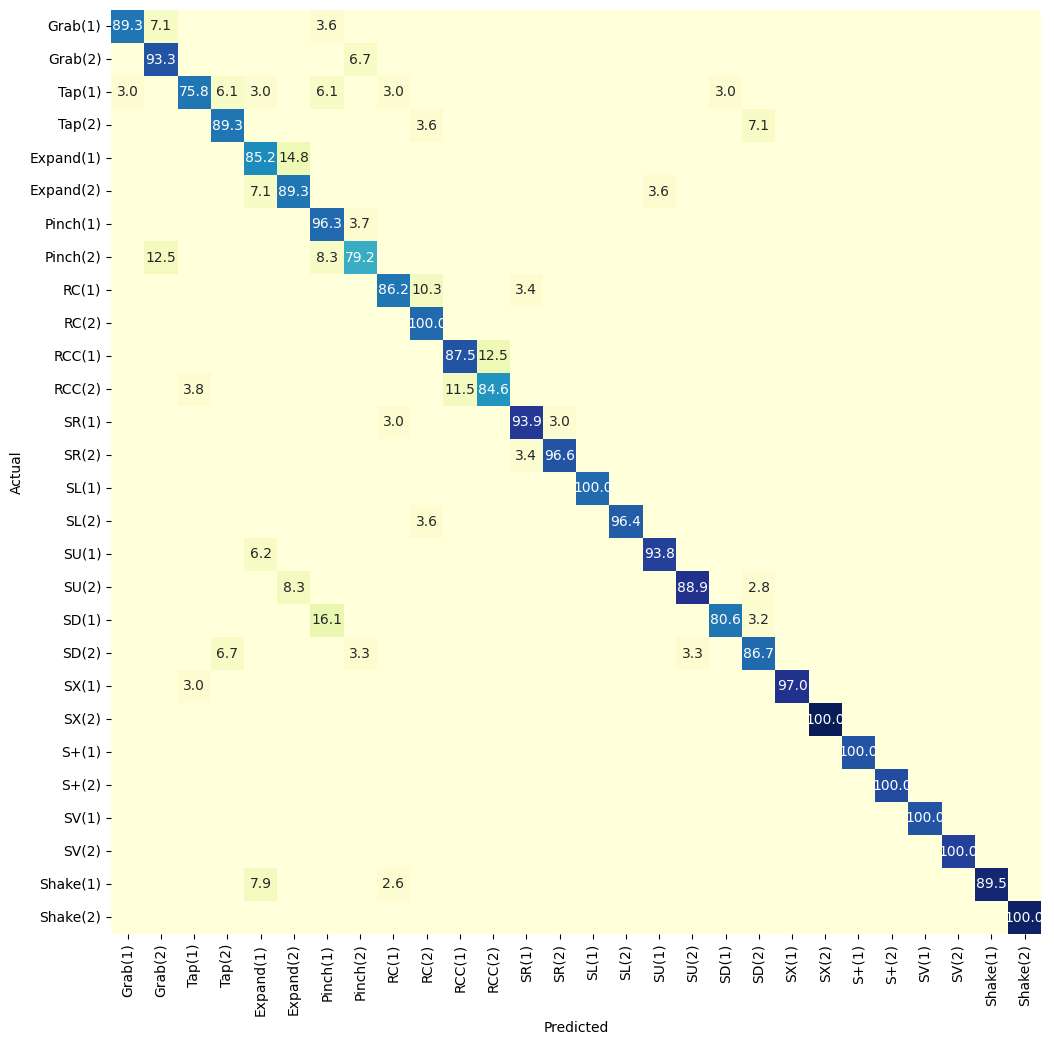

In [24]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_28_2.png', labels, ymap=None, figsize=(12,12))

# Policy gradient for frame selection  -------train

In [25]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable 
from torch.nn import Linear,ReLU,CrossEntropyLoss,Sequential,Conv2d,MaxPool2d,Module,Softmax,BatchNorm2d,Dropout
from torch.optim import Adam,SGD

from numpy.random import default_rng
from utils import *

from numpy.random import default_rng


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")



gamma = 0.7



class Policy(nn.Module):
    def __init__(self, n_states, n_actions, hidden_size, learning_rate=1e-4):
        super(Policy, self).__init__()

        self.n_actions = n_actions 

        self.cnn_layers = Sequential(Conv2d(1, 32, kernel_size=2),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(32, 64, kernel_size=3, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(64, 128, kernel_size=2, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),) 

        self.linear_layers = Sequential(
            Linear(8448,3))  #20 3960  #10 1980 #30 8448
#         optimizer = Adam(model.parameters(), lr=0.001)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):  
        x = x.float()
        x = self.cnn_layers(x)
        # x=x.size
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = F.softmax(x, dim=1)
        return x 
    
    def select_action(self, state):  
        # state = torch.from_numpy(state).float().unsqueeze(0)
        pr = self.forward(Variable(state))   #Variable进行自动微分；
        act = np.random.choice(self.n_actions, p=np.squeeze(pr.detach().numpy())) 
        log_pr = torch.log(pr.squeeze(0)[act]) 
        return act, log_pr
  
            
def update_policy(policy_network, rewards, log_probs): 
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        count = 0
        for r in rewards[t:]:
            Gt = Gt + gamma**count * r     
            count +=count
        discounted_rewards.append(Gt)
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-4) 
    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()


def calculate_reward(Probs, Probs_history , true_class): 
  ## Probs is the outcome of softmax layer from classifier CNN # Probs : N_classes * 1
  ## Probs_history i the output of previous iteration
  ## true_class is an integer from [1-10]
  ## iteration is the number of iterations passed from the beginning
  omega = 25 # a measure of how strong are the punishments and stimulations
  predicted_class = np.argmax(Probs) + 1
  prev_predicted_class = np.argmax(Probs_history) + 1  ## +1 is bcz classes are from 1 to 10
  
  
  if (predicted_class == true_class and not(prev_predicted_class == true_class) ):
    reward = omega  ## stimulation
  elif ( not(predicted_class == true_class) and (prev_predicted_class == true_class) ):
    reward = - omega ## punishment
  else:
    true_class = int(true_class)
    reward = 7*(np.sign(Probs[true_class - 1]  - Probs_history[true_class - 1]))## -1 is bcz classes are from 1 to 10

  return reward   

def train(oridata,labels): 
    n_states=32 
    n_actions=3 
    # env.seed(random_seed)
    policy_net = Policy(n_states, n_actions, 128) 
    max_episode_num = 1
    max_steps = 20  
    all_rewards = []
    label_new=[]
    final_ind=[]
    for episode in tqdm(range(max_episode_num)):        
        rewards2=[]
        x_tr=[]
        for v in tqdm(range(len(oridata))):
            log_probs = []
            rewards = []
            Action=[]
            if len(oridata[v])>=32:
                rng = default_rng()
                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=False))   
            else:
                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=True))  
            XX=oridata[v]  
            original_fr=XX.clone().detach() 
            original_label=labels[v].numpy()
            
            for steps in range(len(MM)):
                state = original_fr[MM[steps]]
                state = state.reshape(1, 1, 22, 3)
                state = torch.Tensor(state)
                action, log_prob = policy_net.select_action(state)
                Action.append(action)

                if action == 0 :
                    if steps == 0:
                        a = 0
                    else:
                        a = math.ceil(((MM[steps - 1]) + MM[steps]) / 2)
                    d = min(1, MM[steps] - a)
                    MM[steps] = MM[steps] - d
                if action == 1:
                    MM[steps] = MM[steps]
                if action == 2:
                    if steps == len(MM) - 1:
                        a = len(original_fr)
                    else:
                        a = math.ceil((MM[steps] + MM[steps + 1]) / 2)
                    d = min(1, a - MM[steps] - 1)
                    MM[steps] = MM[steps] + d

                xm1 = XX[MM]
                xmm = xm1
                q = np.array(xm1).reshape([32,22,3])
                q = zoom(q,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)

                M = get_CG(q,C)  
                q = q.reshape(1,32,22,3)
                M = M.reshape(1,32,231)

                original_fr = XX
                output = DD_Net.predict([M,q])       
                prob = output
                prediction = np.argmax(output,axis=1)

                prob=prob[0]
                if (steps == 0):
                  reward = 1 if prediction==original_label else -1   
                else:
                  reward=calculate_reward(prob, Probs_history ,original_label)
                Probs_history=prob 
                log_probs.append(log_prob)
                rewards.append(reward)
            
                if steps==len(MM) - 1:
                    xm1_step = XX[MM]
            x_tr.append(xm1_step)
            rewards2.append(np.mean(rewards))
            update_policy(policy_net, rewards, log_probs)    
            label_new.append(original_label)
        x_tr = torch.stack(x_tr)
        print(x_tr)   
        if episode==max_episode_num-1:
          final_ind.append(Action)
            

        
        R=np.sum((rewards2))
        all_rewards.append(R)
 
    return all_rewards,x_tr,policy_net

/home/l/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
Train = pickle.load(open(C.data_dir+"train.pkl","rb"))


oridata = []


for i in tqdm(range(len(Train['pose']))):
    ori = np.copy(Train['pose'][i]).reshape([-1,22,3]) 
    ori = torch.tensor(ori)
    oridata.append(ori)
    

labels = [int(Train['fine_label'][i]) for i in (range(len(Train['pose'])))]
labels = torch.Tensor(labels)
labels_original = labels

100%|████████████████████████████████████| 1960/1960 [00:00<00:00, 33670.15it/s]


In [27]:
all_rewards,x_trnew,policy_net=train(oridata,labels_original)

  5%|█▉                                       | 95/1960 [01:05<22:58,  1.35it/s]


 10%|███▉                                    | 192/1960 [02:15<21:26,  1.37it/s]


 15%|█████▉                                  | 289/1960 [03:26<21:02,  1.32it/s]


 20%|███████▉                                | 386/1960 [04:39<18:41,  1.40it/s]


 25%|█████████▊                              | 483/1960 [05:50<18:20,  1.34it/s]


 30%|███████████▊                            | 580/1960 [07:03<17:24,  1.32it/s]


 35%|█████████████▊                          | 677/1960 [08:15<15:10,  1.41it/s]


 39%|███████████████▊                        | 774/1960 [09:27<14:43,  1.34it/s]


 44%|█████████████████▊                      | 871/1960 [10:39<13:13,  1.37it/s]


 49%|███████████████████▊                    | 968/1960 [11:50<11:38,  1.42it/s]


 54%|█████████████████████▏                 | 1065/1960 [13:03<11:24,  1.31it/s]


 59%|███████████████████████                | 1162/1960 [14:15<10:23,  1.28it/s]


 64%|█████████████████████████              | 1259/1960 [15:28<08:26,  1.38it/s]


 69%|██████████████████████████▉            | 1356/1960 [16:41<07:46,  1.29it/s]


 74%|████████████████████████████▉          | 1453/1960 [17:54<06:24,  1.32it/s]


 79%|██████████████████████████████▊        | 1550/1960 [19:07<05:01,  1.36it/s]


 84%|████████████████████████████████▊      | 1647/1960 [20:19<04:02,  1.29it/s]


 89%|██████████████████████████████████▋    | 1744/1960 [21:31<02:43,  1.32it/s]


 94%|████████████████████████████████████▋  | 1841/1960 [22:44<01:23,  1.43it/s]


 99%|██████████████████████████████████████▌| 1938/1960 [23:55<00:16,  1.33it/s]


100%|███████████████████████████████████████████| 1/1 [24:10<00:00, 1450.81s/it]

tensor([[[[ 0.3532, -0.3600,  0.4674],
          [ 0.3546, -0.3192,  0.4629],
          [ 0.3302, -0.3392,  0.4603],
          ...,
          [ 0.3992, -0.2919,  0.4620],
          [ 0.4074, -0.2905,  0.4688],
          [ 0.4283, -0.3102,  0.4830]],

         [[ 0.3254, -0.3258,  0.4170],
          [ 0.3364, -0.2970,  0.4306],
          [ 0.3061, -0.3000,  0.4115],
          ...,
          [ 0.4013, -0.2886,  0.4582],
          [ 0.4076, -0.2779,  0.4587],
          [ 0.4136, -0.2679,  0.4592]],

         [[ 0.2959, -0.2566,  0.3556],
          [ 0.3159, -0.2608,  0.3853],
          [ 0.2796, -0.2520,  0.3585],
          ...,
          [ 0.3894, -0.2507,  0.4278],
          [ 0.3993, -0.2408,  0.4373],
          [ 0.4127, -0.2382,  0.4456]],

         ...,

         [[ 0.2726, -0.2460,  0.3046],
          [ 0.2553, -0.1934,  0.2919],
          [ 0.2419, -0.2258,  0.2903],
          ...,
          [ 0.3005, -0.1714,  0.2906],
          [ 0.2910, -0.1844,  0.2807],
          [ 0.2892, -0

In [28]:
print(all_rewards)
#plt.plot(all_rewards)
#plt.xlabel('number of epoches')
#plt.ylabel('the average reward')
#plt.savefig("/media/l/data/HRC/HRC_intention_recognition/code/DD-Net-master/SHREC/images/RLsherc_14_reward_fine.png")
#plt.grid()

[-45.71875]


In [29]:
X_4 =[]
X_5 = []
labels_rl = []

for i in tqdm(range(len(x_trnew))):
    w_p = np.copy(x_trnew[i]).reshape([-1,22,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_fine)
    label_rl[int(labels[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

100%|██████████████████████████████████████| 1960/1960 [00:15<00:00, 128.08it/s]


In [30]:

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/600
1960/1960 [==============================] - 4s 2ms/step - loss: 0.1134 - accuracy: 0.9806 - val_loss: 0.4698 - val_accuracy: 0.8786
Epoch 2/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.1666 - accuracy: 0.9638 - val_loss: 0.4428 - val_accuracy: 0.8833
Epoch 3/600
1960/1960 [==============================] - 0s 103us/step - loss: 0.1535 - accuracy: 0.9684 - val_loss: 0.4825 - val_accuracy: 0.8845
Epoch 4/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.1531 - accuracy: 0.9653 - val_loss: 0.5370 - val_accuracy: 0.8738
Epoch 5/600
1960/1960 [==============================] - 0s 103us/step - loss: 0.1430 - accuracy: 0.9653 - val_loss: 0.4987 - val_accuracy: 0.8821
Epoch 6/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.1279 - accuracy: 0.9699 - val_loss: 0.5122 - val_accuracy: 0.8845
Epoch 7/600
1960/1960 [==============================] - 0s 102us/step - 

Epoch 57/600
1960/1960 [==============================] - 0s 98us/step - loss: 0.0420 - accuracy: 0.9939 - val_loss: 0.3722 - val_accuracy: 0.9179
Epoch 58/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0463 - accuracy: 0.9959 - val_loss: 0.3710 - val_accuracy: 0.9179
Epoch 59/600
1960/1960 [==============================] - 0s 101us/step - loss: 0.0435 - accuracy: 0.9939 - val_loss: 0.3697 - val_accuracy: 0.9202
Epoch 60/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0401 - accuracy: 0.9964 - val_loss: 0.3687 - val_accuracy: 0.9214
Epoch 61/600
1960/1960 [==============================] - 0s 99us/step - loss: 0.0419 - accuracy: 0.9964 - val_loss: 0.3681 - val_accuracy: 0.9214
Epoch 62/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0482 - accuracy: 0.9964 - val_loss: 0.3655 - val_accuracy: 0.9226
Epoch 63/600
1960/1960 [==============================] - 0s 101us/step - loss: 0.0454 - accuracy: 0.9944 - val_lo

Epoch 113/600
1960/1960 [==============================] - 0s 110us/step - loss: 0.0434 - accuracy: 0.9944 - val_loss: 0.3643 - val_accuracy: 0.9262
Epoch 114/600
1960/1960 [==============================] - 0s 148us/step - loss: 0.0377 - accuracy: 0.9954 - val_loss: 0.3643 - val_accuracy: 0.9262
Epoch 115/600
1960/1960 [==============================] - 0s 112us/step - loss: 0.0359 - accuracy: 0.9980 - val_loss: 0.3643 - val_accuracy: 0.9262
Epoch 116/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0433 - accuracy: 0.9954 - val_loss: 0.3644 - val_accuracy: 0.9262
Epoch 117/600
1960/1960 [==============================] - 0s 107us/step - loss: 0.0338 - accuracy: 0.9980 - val_loss: 0.3644 - val_accuracy: 0.9262
Epoch 118/600
1960/1960 [==============================] - 0s 146us/step - loss: 0.0360 - accuracy: 0.9974 - val_loss: 0.3645 - val_accuracy: 0.9262
Epoch 119/600
1960/1960 [==============================] - 0s 110us/step - loss: 0.0364 - accuracy: 0.9944

Epoch 168/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0348 - accuracy: 0.9980 - val_loss: 0.3676 - val_accuracy: 0.9238
Epoch 169/600
1960/1960 [==============================] - 0s 101us/step - loss: 0.0371 - accuracy: 0.9964 - val_loss: 0.3678 - val_accuracy: 0.9238
Epoch 170/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0403 - accuracy: 0.9959 - val_loss: 0.3678 - val_accuracy: 0.9238
Epoch 171/600
1960/1960 [==============================] - 0s 102us/step - loss: 0.0414 - accuracy: 0.9944 - val_loss: 0.3678 - val_accuracy: 0.9238
Epoch 172/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0380 - accuracy: 0.9959 - val_loss: 0.3679 - val_accuracy: 0.9238
Epoch 173/600
1960/1960 [==============================] - 0s 99us/step - loss: 0.0333 - accuracy: 0.9980 - val_loss: 0.3680 - val_accuracy: 0.9238
Epoch 174/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0386 - accuracy: 0.9959 

Epoch 223/600
1960/1960 [==============================] - 0s 109us/step - loss: 0.0398 - accuracy: 0.9949 - val_loss: 0.3680 - val_accuracy: 0.9250
Epoch 224/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0405 - accuracy: 0.9954 - val_loss: 0.3680 - val_accuracy: 0.9250
Epoch 225/600
1960/1960 [==============================] - 0s 107us/step - loss: 0.0371 - accuracy: 0.9969 - val_loss: 0.3680 - val_accuracy: 0.9250
Epoch 226/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0371 - accuracy: 0.9974 - val_loss: 0.3681 - val_accuracy: 0.9250
Epoch 227/600
1960/1960 [==============================] - 0s 109us/step - loss: 0.0365 - accuracy: 0.9954 - val_loss: 0.3682 - val_accuracy: 0.9250
Epoch 228/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0365 - accuracy: 0.9959 - val_loss: 0.3683 - val_accuracy: 0.9250
Epoch 229/600
1960/1960 [==============================] - 0s 109us/step - loss: 0.0404 - accuracy: 0.9974

Epoch 278/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0320 - accuracy: 0.9985 - val_loss: 0.3725 - val_accuracy: 0.9250
Epoch 279/600
1960/1960 [==============================] - 0s 102us/step - loss: 0.0329 - accuracy: 0.9969 - val_loss: 0.3726 - val_accuracy: 0.9250
Epoch 280/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0332 - accuracy: 0.9980 - val_loss: 0.3729 - val_accuracy: 0.9250
Epoch 281/600
1960/1960 [==============================] - 0s 101us/step - loss: 0.0302 - accuracy: 0.9985 - val_loss: 0.3731 - val_accuracy: 0.9250
Epoch 282/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0381 - accuracy: 0.9964 - val_loss: 0.3733 - val_accuracy: 0.9250
Epoch 283/600
1960/1960 [==============================] - 0s 100us/step - loss: 0.0366 - accuracy: 0.9954 - val_loss: 0.3735 - val_accuracy: 0.9250
Epoch 284/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0346 - accuracy: 0.9980

1960/1960 [==============================] - 0s 107us/step - loss: 0.0348 - accuracy: 0.9954 - val_loss: 0.3745 - val_accuracy: 0.9250
Epoch 334/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0352 - accuracy: 0.9985 - val_loss: 0.3746 - val_accuracy: 0.9250
Epoch 335/600
1960/1960 [==============================] - 0s 108us/step - loss: 0.0366 - accuracy: 0.9959 - val_loss: 0.3746 - val_accuracy: 0.9250
Epoch 336/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0329 - accuracy: 0.9969 - val_loss: 0.3747 - val_accuracy: 0.9250
Epoch 337/600
1960/1960 [==============================] - 0s 108us/step - loss: 0.0336 - accuracy: 0.9964 - val_loss: 0.3746 - val_accuracy: 0.9250
Epoch 338/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0317 - accuracy: 0.9969 - val_loss: 0.3746 - val_accuracy: 0.9250
Epoch 339/600
1960/1960 [==============================] - 0s 110us/step - loss: 0.0340 - accuracy: 0.9969 - val_loss: 0

1960/1960 [==============================] - 0s 146us/step - loss: 0.0312 - accuracy: 0.9980 - val_loss: 0.3751 - val_accuracy: 0.9250
Epoch 389/600
1960/1960 [==============================] - 0s 110us/step - loss: 0.0392 - accuracy: 0.9964 - val_loss: 0.3751 - val_accuracy: 0.9250
Epoch 390/600
1960/1960 [==============================] - 0s 147us/step - loss: 0.0342 - accuracy: 0.9974 - val_loss: 0.3751 - val_accuracy: 0.9250
Epoch 391/600
1960/1960 [==============================] - 0s 108us/step - loss: 0.0311 - accuracy: 0.9974 - val_loss: 0.3751 - val_accuracy: 0.9250
Epoch 392/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0323 - accuracy: 0.9985 - val_loss: 0.3751 - val_accuracy: 0.9250
Epoch 393/600
1960/1960 [==============================] - 0s 108us/step - loss: 0.0437 - accuracy: 0.9949 - val_loss: 0.3751 - val_accuracy: 0.9250
Epoch 394/600
1960/1960 [==============================] - 0s 147us/step - loss: 0.0357 - accuracy: 0.9980 - val_loss: 0

Epoch 444/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0349 - accuracy: 0.9959 - val_loss: 0.3768 - val_accuracy: 0.9250
Epoch 445/600
1960/1960 [==============================] - 0s 101us/step - loss: 0.0391 - accuracy: 0.9939 - val_loss: 0.3769 - val_accuracy: 0.9250
Epoch 446/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0405 - accuracy: 0.9934 - val_loss: 0.3772 - val_accuracy: 0.9250
Epoch 447/600
1960/1960 [==============================] - 0s 100us/step - loss: 0.0332 - accuracy: 0.9980 - val_loss: 0.3775 - val_accuracy: 0.9250
Epoch 448/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0310 - accuracy: 0.9964 - val_loss: 0.3779 - val_accuracy: 0.9250
Epoch 449/600
1960/1960 [==============================] - 0s 102us/step - loss: 0.0378 - accuracy: 0.9964 - val_loss: 0.3782 - val_accuracy: 0.9250
Epoch 450/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0302 - accuracy: 0.9980

Epoch 499/600
1960/1960 [==============================] - 0s 101us/step - loss: 0.0300 - accuracy: 0.9985 - val_loss: 0.3778 - val_accuracy: 0.9250
Epoch 500/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0319 - accuracy: 0.9974 - val_loss: 0.3778 - val_accuracy: 0.9250
Epoch 501/600
1960/1960 [==============================] - 0s 105us/step - loss: 0.0303 - accuracy: 0.9974 - val_loss: 0.3778 - val_accuracy: 0.9250
Epoch 502/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0337 - accuracy: 0.9974 - val_loss: 0.3778 - val_accuracy: 0.9250
Epoch 503/600
1960/1960 [==============================] - 0s 102us/step - loss: 0.0307 - accuracy: 0.9959 - val_loss: 0.3778 - val_accuracy: 0.9250
Epoch 504/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0350 - accuracy: 0.9959 - val_loss: 0.3777 - val_accuracy: 0.9250
Epoch 505/600
1960/1960 [==============================] - 0s 109us/step - loss: 0.0332 - accuracy: 0.9969

Epoch 554/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0392 - accuracy: 0.9974 - val_loss: 0.3773 - val_accuracy: 0.9226
Epoch 555/600
1960/1960 [==============================] - 0s 103us/step - loss: 0.0306 - accuracy: 0.9985 - val_loss: 0.3772 - val_accuracy: 0.9226
Epoch 556/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0326 - accuracy: 0.9969 - val_loss: 0.3773 - val_accuracy: 0.9226
Epoch 557/600
1960/1960 [==============================] - 0s 101us/step - loss: 0.0280 - accuracy: 0.9990 - val_loss: 0.3773 - val_accuracy: 0.9226
Epoch 558/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0286 - accuracy: 0.9990 - val_loss: 0.3773 - val_accuracy: 0.9226
Epoch 559/600
1960/1960 [==============================] - 0s 107us/step - loss: 0.0367 - accuracy: 0.9969 - val_loss: 0.3773 - val_accuracy: 0.9226
Epoch 560/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0364 - accuracy: 0.9969

In [31]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [32]:
labels_train = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']
y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels_train[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels_train[i])

In [33]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.925


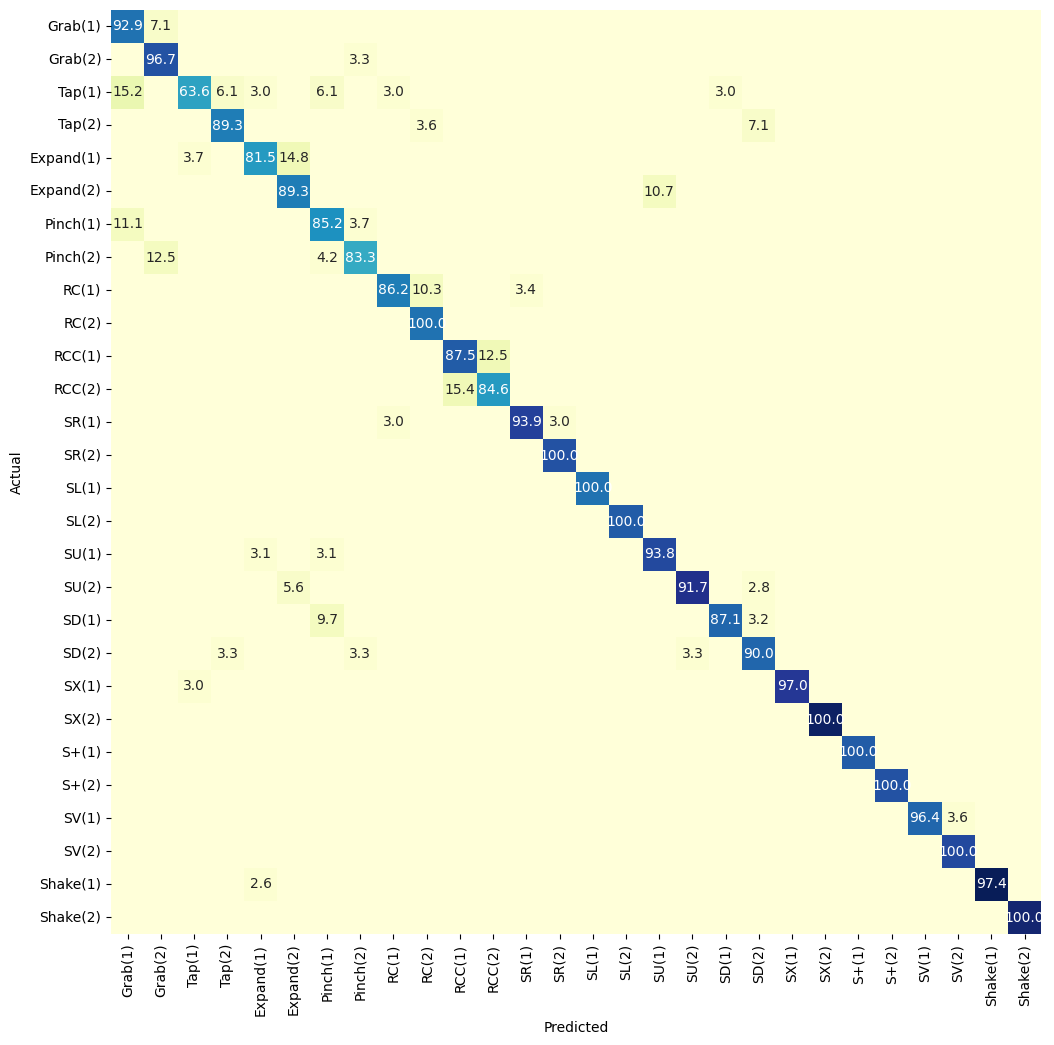

In [34]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_28_3.png', labels_train, ymap=None, figsize=(12,12))

### epoch 2 

In [35]:
all_rewards,x_trnew_2,policy_net=train(x_trnew,labels_original)

  5%|█▉                                       | 95/1960 [01:11<23:26,  1.33it/s]


 10%|███▉                                    | 192/1960 [02:25<22:13,  1.33it/s]


 15%|█████▉                                  | 289/1960 [03:39<21:58,  1.27it/s]


 20%|███████▉                                | 386/1960 [04:52<20:38,  1.27it/s]


 25%|█████████▊                              | 483/1960 [06:06<18:55,  1.30it/s]


 30%|███████████▊                            | 580/1960 [07:21<18:26,  1.25it/s]


 35%|█████████████▊                          | 677/1960 [08:35<15:39,  1.37it/s]


 39%|███████████████▊                        | 774/1960 [09:49<15:03,  1.31it/s]


 44%|█████████████████▊                      | 871/1960 [11:02<13:53,  1.31it/s]


 49%|███████████████████▊                    | 968/1960 [12:14<11:39,  1.42it/s]


 54%|█████████████████████▏                 | 1065/1960 [13:25<11:27,  1.30it/s]


 59%|███████████████████████                | 1162/1960 [14:39<10:21,  1.28it/s]


 64%|█████████████████████████              | 1259/1960 [15:51<08:26,  1.38it/s]


 69%|██████████████████████████▉            | 1356/1960 [17:01<07:05,  1.42it/s]


 74%|████████████████████████████▉          | 1453/1960 [18:13<05:59,  1.41it/s]


 79%|██████████████████████████████▊        | 1550/1960 [19:25<04:49,  1.42it/s]


 84%|████████████████████████████████▊      | 1647/1960 [20:37<04:12,  1.24it/s]


 89%|██████████████████████████████████▋    | 1744/1960 [21:51<02:41,  1.34it/s]


 94%|████████████████████████████████████▋  | 1841/1960 [23:05<01:29,  1.33it/s]


 99%|██████████████████████████████████████▌| 1938/1960 [24:19<00:17,  1.27it/s]


100%|███████████████████████████████████████████| 1/1 [24:36<00:00, 1476.51s/it]

tensor([[[[ 0.3532, -0.3600,  0.4674],
          [ 0.3546, -0.3192,  0.4629],
          [ 0.3302, -0.3392,  0.4603],
          ...,
          [ 0.3992, -0.2919,  0.4620],
          [ 0.4074, -0.2905,  0.4688],
          [ 0.4283, -0.3102,  0.4830]],

         [[ 0.3254, -0.3258,  0.4170],
          [ 0.3364, -0.2970,  0.4306],
          [ 0.3061, -0.3000,  0.4115],
          ...,
          [ 0.4013, -0.2886,  0.4582],
          [ 0.4076, -0.2779,  0.4587],
          [ 0.4136, -0.2679,  0.4592]],

         [[ 0.2959, -0.2566,  0.3556],
          [ 0.3159, -0.2608,  0.3853],
          [ 0.2796, -0.2520,  0.3585],
          ...,
          [ 0.3894, -0.2507,  0.4278],
          [ 0.3993, -0.2408,  0.4373],
          [ 0.4127, -0.2382,  0.4456]],

         ...,

         [[ 0.2726, -0.2460,  0.3046],
          [ 0.2553, -0.1934,  0.2919],
          [ 0.2419, -0.2258,  0.2903],
          ...,
          [ 0.3005, -0.1714,  0.2906],
          [ 0.2910, -0.1844,  0.2807],
          [ 0.2892, -0

In [36]:
print(all_rewards)

[-61.25]


In [39]:
X_4 =[]
X_5 = []
labels_rl = []

for i in tqdm(range(len(x_trnew_2))):
    w_p = np.copy(x_trnew_2[i]).reshape([-1,22,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_fine)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

100%|██████████████████████████████████████| 1960/1960 [00:15<00:00, 123.11it/s]


In [40]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/600
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0382 - accuracy: 0.9964 - val_loss: 0.4481 - val_accuracy: 0.9131
Epoch 2/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0765 - accuracy: 0.9842 - val_loss: 0.4883 - val_accuracy: 0.9048
Epoch 3/600
1960/1960 [==============================] - 0s 123us/step - loss: 0.0953 - accuracy: 0.9842 - val_loss: 0.4985 - val_accuracy: 0.9012
Epoch 4/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0706 - accuracy: 0.9883 - val_loss: 0.4890 - val_accuracy: 0.9083
Epoch 5/600
1960/1960 [==============================] - 0s 122us/step - loss: 0.0803 - accuracy: 0.9842 - val_loss: 0.4625 - val_accuracy: 0.9190
Epoch 6/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0770 - accuracy: 0.9827 - val_loss: 0.4645 - val_accuracy: 0.9179
Epoch 7/600
1960/1960 [==============================] - 0s 119us/step - 

Epoch 57/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0229 - accuracy: 0.9974 - val_loss: 0.3812 - val_accuracy: 0.9250
Epoch 58/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0246 - accuracy: 0.9985 - val_loss: 0.3802 - val_accuracy: 0.9238
Epoch 59/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0237 - accuracy: 0.9980 - val_loss: 0.3794 - val_accuracy: 0.9238
Epoch 60/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0257 - accuracy: 0.9974 - val_loss: 0.3788 - val_accuracy: 0.9238
Epoch 61/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0278 - accuracy: 0.9954 - val_loss: 0.3782 - val_accuracy: 0.9226
Epoch 62/600
1960/1960 [==============================] - 0s 150us/step - loss: 0.0290 - accuracy: 0.9959 - val_loss: 0.3783 - val_accuracy: 0.9238
Epoch 63/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0215 - accuracy: 0.9995 - val_

Epoch 113/600
1960/1960 [==============================] - 0s 119us/step - loss: 0.0229 - accuracy: 0.9980 - val_loss: 0.3991 - val_accuracy: 0.9310
Epoch 114/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0211 - accuracy: 0.9990 - val_loss: 0.3992 - val_accuracy: 0.9310
Epoch 115/600
1960/1960 [==============================] - 0s 116us/step - loss: 0.0213 - accuracy: 0.9995 - val_loss: 0.3992 - val_accuracy: 0.9310
Epoch 116/600
1960/1960 [==============================] - 0s 126us/step - loss: 0.0223 - accuracy: 0.9969 - val_loss: 0.3993 - val_accuracy: 0.9310
Epoch 117/600
1960/1960 [==============================] - 0s 116us/step - loss: 0.0229 - accuracy: 0.9980 - val_loss: 0.3994 - val_accuracy: 0.9310
Epoch 118/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0219 - accuracy: 1.0000 - val_loss: 0.3994 - val_accuracy: 0.9310
Epoch 119/600
1960/1960 [==============================] - 0s 119us/step - loss: 0.0211 - accuracy: 0.9985

Epoch 168/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0214 - accuracy: 0.9985 - val_loss: 0.3989 - val_accuracy: 0.9298
Epoch 169/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0239 - accuracy: 0.9964 - val_loss: 0.3989 - val_accuracy: 0.9298
Epoch 170/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0196 - accuracy: 0.9990 - val_loss: 0.3990 - val_accuracy: 0.9298
Epoch 171/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0212 - accuracy: 0.9980 - val_loss: 0.3991 - val_accuracy: 0.9298
Epoch 172/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0205 - accuracy: 0.9990 - val_loss: 0.3992 - val_accuracy: 0.9298
Epoch 173/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0243 - accuracy: 0.9964 - val_loss: 0.3992 - val_accuracy: 0.9298
Epoch 174/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0203 - accuracy: 0.9990

Epoch 223/600
1960/1960 [==============================] - 0s 121us/step - loss: 0.0216 - accuracy: 0.9985 - val_loss: 0.4009 - val_accuracy: 0.9310
Epoch 224/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0209 - accuracy: 0.9990 - val_loss: 0.4009 - val_accuracy: 0.9310
Epoch 225/600
1960/1960 [==============================] - 0s 121us/step - loss: 0.0227 - accuracy: 0.9980 - val_loss: 0.4009 - val_accuracy: 0.9310
Epoch 226/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0220 - accuracy: 0.9964 - val_loss: 0.4009 - val_accuracy: 0.9310
Epoch 227/600
1960/1960 [==============================] - 0s 121us/step - loss: 0.0242 - accuracy: 0.9964 - val_loss: 0.4010 - val_accuracy: 0.9310
Epoch 228/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.4009 - val_accuracy: 0.9310
Epoch 229/600
1960/1960 [==============================] - 0s 120us/step - loss: 0.0249 - accuracy: 0.9974

Epoch 278/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0237 - accuracy: 0.9990 - val_loss: 0.4014 - val_accuracy: 0.9298
Epoch 279/600
1960/1960 [==============================] - 0s 120us/step - loss: 0.0191 - accuracy: 0.9990 - val_loss: 0.4014 - val_accuracy: 0.9298
Epoch 280/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0201 - accuracy: 0.9985 - val_loss: 0.4014 - val_accuracy: 0.9298
Epoch 281/600
1960/1960 [==============================] - 0s 120us/step - loss: 0.0191 - accuracy: 0.9980 - val_loss: 0.4014 - val_accuracy: 0.9298
Epoch 282/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.4014 - val_accuracy: 0.9298
Epoch 283/600
1960/1960 [==============================] - 0s 120us/step - loss: 0.0213 - accuracy: 0.9969 - val_loss: 0.4014 - val_accuracy: 0.9310
Epoch 284/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0201 - accuracy: 0.9990

Epoch 333/600
1960/1960 [==============================] - 0s 117us/step - loss: 0.0191 - accuracy: 0.9985 - val_loss: 0.4024 - val_accuracy: 0.9310
Epoch 334/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0183 - accuracy: 0.9995 - val_loss: 0.4025 - val_accuracy: 0.9310
Epoch 335/600
1960/1960 [==============================] - 0s 118us/step - loss: 0.0208 - accuracy: 0.9980 - val_loss: 0.4025 - val_accuracy: 0.9310
Epoch 336/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0229 - accuracy: 0.9974 - val_loss: 0.4026 - val_accuracy: 0.9310
Epoch 337/600
1960/1960 [==============================] - 0s 121us/step - loss: 0.0199 - accuracy: 0.9995 - val_loss: 0.4028 - val_accuracy: 0.9310
Epoch 338/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0171 - accuracy: 0.9995 - val_loss: 0.4028 - val_accuracy: 0.9310
Epoch 339/600
1960/1960 [==============================] - 0s 121us/step - loss: 0.0201 - accuracy: 0.9995

Epoch 388/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0231 - accuracy: 0.9969 - val_loss: 0.4033 - val_accuracy: 0.9286
Epoch 389/600
1960/1960 [==============================] - 0s 118us/step - loss: 0.0204 - accuracy: 0.9980 - val_loss: 0.4034 - val_accuracy: 0.9286
Epoch 390/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0229 - accuracy: 0.9969 - val_loss: 0.4035 - val_accuracy: 0.9286
Epoch 391/600
1960/1960 [==============================] - 0s 119us/step - loss: 0.0215 - accuracy: 0.9980 - val_loss: 0.4035 - val_accuracy: 0.9286
Epoch 392/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0236 - accuracy: 0.9990 - val_loss: 0.4036 - val_accuracy: 0.9286
Epoch 393/600
1960/1960 [==============================] - 0s 121us/step - loss: 0.0197 - accuracy: 0.9990 - val_loss: 0.4037 - val_accuracy: 0.9286
Epoch 394/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0199 - accuracy: 0.9995

Epoch 443/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0197 - accuracy: 0.9995 - val_loss: 0.4059 - val_accuracy: 0.9286
Epoch 444/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0229 - accuracy: 0.9980 - val_loss: 0.4060 - val_accuracy: 0.9286
Epoch 445/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0190 - accuracy: 0.9980 - val_loss: 0.4060 - val_accuracy: 0.9286
Epoch 446/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0270 - accuracy: 0.9974 - val_loss: 0.4060 - val_accuracy: 0.9286
Epoch 447/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0224 - accuracy: 0.9980 - val_loss: 0.4060 - val_accuracy: 0.9286
Epoch 448/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0195 - accuracy: 0.9980 - val_loss: 0.4060 - val_accuracy: 0.9286
Epoch 449/600
1960/1960 [==============================] - 0s 118us/step - loss: 0.0158 - accuracy: 0.9995

Epoch 498/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0191 - accuracy: 0.9995 - val_loss: 0.4016 - val_accuracy: 0.9298
Epoch 499/600
1960/1960 [==============================] - 0s 121us/step - loss: 0.0189 - accuracy: 0.9995 - val_loss: 0.4016 - val_accuracy: 0.9298
Epoch 500/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0228 - accuracy: 0.9959 - val_loss: 0.4015 - val_accuracy: 0.9298
Epoch 501/600
1960/1960 [==============================] - 0s 123us/step - loss: 0.0208 - accuracy: 0.9980 - val_loss: 0.4015 - val_accuracy: 0.9298
Epoch 502/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0186 - accuracy: 0.9980 - val_loss: 0.4014 - val_accuracy: 0.9298
Epoch 503/600
1960/1960 [==============================] - 0s 124us/step - loss: 0.0191 - accuracy: 0.9990 - val_loss: 0.4014 - val_accuracy: 0.9298
Epoch 504/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0222 - accuracy: 0.9990

Epoch 553/600
1960/1960 [==============================] - 0s 120us/step - loss: 0.0188 - accuracy: 0.9995 - val_loss: 0.4021 - val_accuracy: 0.9298
Epoch 554/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0179 - accuracy: 0.9990 - val_loss: 0.4022 - val_accuracy: 0.9298
Epoch 555/600
1960/1960 [==============================] - 0s 123us/step - loss: 0.0172 - accuracy: 0.9995 - val_loss: 0.4023 - val_accuracy: 0.9298
Epoch 556/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0220 - accuracy: 0.9980 - val_loss: 0.4025 - val_accuracy: 0.9298
Epoch 557/600
1960/1960 [==============================] - 0s 119us/step - loss: 0.0229 - accuracy: 0.9974 - val_loss: 0.4029 - val_accuracy: 0.9298
Epoch 558/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0185 - accuracy: 0.9990 - val_loss: 0.4033 - val_accuracy: 0.9298
Epoch 559/600
1960/1960 [==============================] - 0s 120us/step - loss: 0.0198 - accuracy: 0.9990

In [41]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9285714285714286


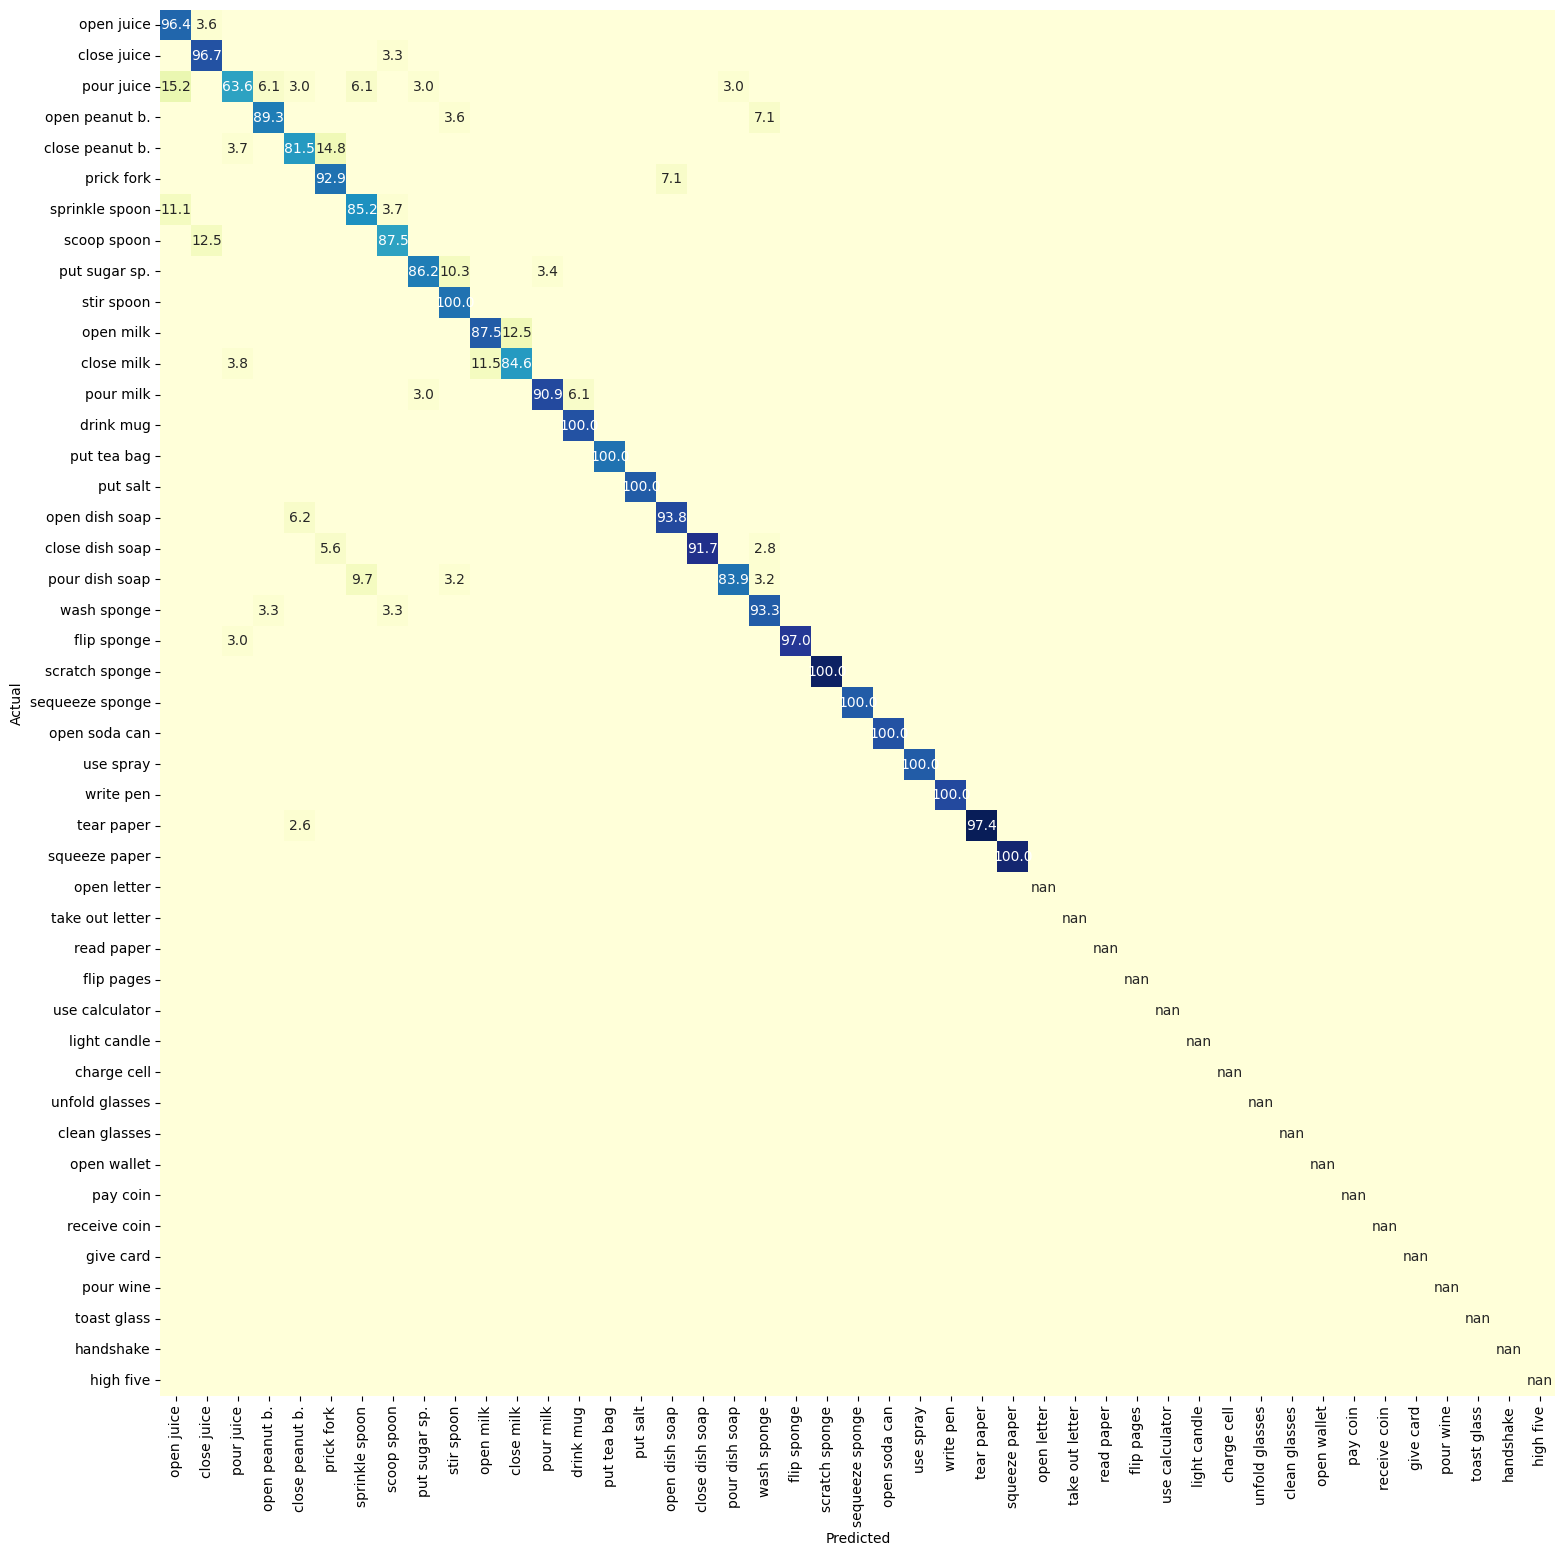

In [42]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_14_5.png', labels, ymap=None, figsize=(18,18))

### epoch 3

In [45]:
all_rewards,x_trnew_3,policy_net=train(x_trnew_2,labels_original)
print(all_rewards)
X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_3))):
    w_p = np.copy(x_trnew_3[i]).reshape([-1,22,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_fine)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

  5%|█▉                                       | 95/1960 [01:12<24:30,  1.27it/s]


 10%|███▉                                    | 192/1960 [02:22<19:29,  1.51it/s]


 15%|█████▉                                  | 289/1960 [03:35<20:06,  1.38it/s]


 20%|███████▉                                | 386/1960 [04:49<20:51,  1.26it/s]


 25%|█████████▊                              | 483/1960 [06:02<17:35,  1.40it/s]


 30%|███████████▊                            | 580/1960 [07:15<17:38,  1.30it/s]


 35%|█████████████▊                          | 677/1960 [08:28<16:03,  1.33it/s]


 39%|███████████████▊                        | 774/1960 [09:42<14:16,  1.38it/s]


 44%|█████████████████▊                      | 871/1960 [10:56<13:34,  1.34it/s]


 49%|███████████████████▊                    | 968/1960 [12:08<12:33,  1.32it/s]


 54%|█████████████████████▏                 | 1065/1960 [13:20<10:50,  1.38it/s]


 59%|███████████████████████                | 1162/1960 [14:31<10:37,  1.25it/s]


 64%|█████████████████████████              | 1259/1960 [15:44<09:06,  1.28it/s]


 69%|██████████████████████████▉            | 1356/1960 [16:56<07:05,  1.42it/s]


 74%|████████████████████████████▉          | 1453/1960 [18:09<06:27,  1.31it/s]


 79%|██████████████████████████████▊        | 1550/1960 [19:21<05:04,  1.34it/s]


 84%|████████████████████████████████▊      | 1647/1960 [20:34<03:45,  1.39it/s]


 89%|██████████████████████████████████▋    | 1744/1960 [21:45<02:37,  1.37it/s]


 94%|████████████████████████████████████▋  | 1841/1960 [22:55<01:24,  1.40it/s]


 99%|██████████████████████████████████████▌| 1938/1960 [24:05<00:15,  1.40it/s]


100%|███████████████████████████████████████████| 1/1 [24:22<00:00, 1462.64s/it]


tensor([[[[ 0.3532, -0.3600,  0.4674],
          [ 0.3546, -0.3192,  0.4629],
          [ 0.3302, -0.3392,  0.4603],
          ...,
          [ 0.3992, -0.2919,  0.4620],
          [ 0.4074, -0.2905,  0.4688],
          [ 0.4283, -0.3102,  0.4830]],

         [[ 0.3254, -0.3258,  0.4170],
          [ 0.3364, -0.2970,  0.4306],
          [ 0.3061, -0.3000,  0.4115],
          ...,
          [ 0.4013, -0.2886,  0.4582],
          [ 0.4076, -0.2779,  0.4587],
          [ 0.4136, -0.2679,  0.4592]],

         [[ 0.2959, -0.2566,  0.3556],
          [ 0.3159, -0.2608,  0.3853],
          [ 0.2796, -0.2520,  0.3585],
          ...,
          [ 0.3894, -0.2507,  0.4278],
          [ 0.3993, -0.2408,  0.4373],
          [ 0.4127, -0.2382,  0.4456]],

         ...,

         [[ 0.2726, -0.2460,  0.3046],
          [ 0.2553, -0.1934,  0.2919],
          [ 0.2419, -0.2258,  0.2903],
          ...,
          [ 0.3005, -0.1714,  0.2906],
          [ 0.2910, -0.1844,  0.2807],
          [ 0.2892, -0

100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 122.31it/s]


In [46]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/600
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0187 - accuracy: 0.9995 - val_loss: 0.4871 - val_accuracy: 0.9048
Epoch 2/600
1960/1960 [==============================] - 0s 107us/step - loss: 0.0494 - accuracy: 0.9913 - val_loss: 0.6294 - val_accuracy: 0.8821
Epoch 3/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0392 - accuracy: 0.9923 - val_loss: 0.6818 - val_accuracy: 0.8607
Epoch 4/600
1960/1960 [==============================] - 0s 102us/step - loss: 0.0531 - accuracy: 0.9903 - val_loss: 0.4418 - val_accuracy: 0.9179
Epoch 5/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0587 - accuracy: 0.9878 - val_loss: 0.4743 - val_accuracy: 0.9226
Epoch 6/600
1960/1960 [==============================] - 0s 105us/step - loss: 0.0373 - accuracy: 0.9944 - val_loss: 0.4679 - val_accuracy: 0.9190
Epoch 7/600
1960/1960 [==============================] - 0s 131us/step - 

Epoch 57/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0213 - accuracy: 0.9974 - val_loss: 0.4649 - val_accuracy: 0.9179
Epoch 58/600
1960/1960 [==============================] - 0s 108us/step - loss: 0.0193 - accuracy: 0.9985 - val_loss: 0.4640 - val_accuracy: 0.9179
Epoch 59/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0182 - accuracy: 0.9990 - val_loss: 0.4630 - val_accuracy: 0.9179
Epoch 60/600
1960/1960 [==============================] - 0s 106us/step - loss: 0.0179 - accuracy: 0.9985 - val_loss: 0.4618 - val_accuracy: 0.9179
Epoch 61/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0199 - accuracy: 0.9985 - val_loss: 0.4604 - val_accuracy: 0.9167
Epoch 62/600
1960/1960 [==============================] - 0s 104us/step - loss: 0.0166 - accuracy: 0.9985 - val_loss: 0.4593 - val_accuracy: 0.9167
Epoch 63/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0172 - accuracy: 0.9990 - val_

Epoch 113/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0174 - accuracy: 0.9990 - val_loss: 0.4386 - val_accuracy: 0.9238
Epoch 114/600
1960/1960 [==============================] - 0s 123us/step - loss: 0.0168 - accuracy: 0.9995 - val_loss: 0.4381 - val_accuracy: 0.9238
Epoch 115/600
1960/1960 [==============================] - 0s 156us/step - loss: 0.0184 - accuracy: 0.9980 - val_loss: 0.4378 - val_accuracy: 0.9238
Epoch 116/600
1960/1960 [==============================] - 0s 123us/step - loss: 0.0181 - accuracy: 0.9980 - val_loss: 0.4374 - val_accuracy: 0.9238
Epoch 117/600
1960/1960 [==============================] - 0s 153us/step - loss: 0.0228 - accuracy: 0.9969 - val_loss: 0.4371 - val_accuracy: 0.9238
Epoch 118/600
1960/1960 [==============================] - 0s 123us/step - loss: 0.0178 - accuracy: 0.9990 - val_loss: 0.4368 - val_accuracy: 0.9238
Epoch 119/600
1960/1960 [==============================] - 0s 152us/step - loss: 0.0154 - accuracy: 0.9995

Epoch 168/600
1960/1960 [==============================] - 0s 105us/step - loss: 0.0166 - accuracy: 0.9995 - val_loss: 0.4295 - val_accuracy: 0.9286
Epoch 169/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0168 - accuracy: 0.9980 - val_loss: 0.4294 - val_accuracy: 0.9286
Epoch 170/600
1960/1960 [==============================] - 0s 102us/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 0.4294 - val_accuracy: 0.9286
Epoch 171/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0199 - accuracy: 0.9985 - val_loss: 0.4292 - val_accuracy: 0.9286
Epoch 172/600
1960/1960 [==============================] - 0s 106us/step - loss: 0.0203 - accuracy: 0.9985 - val_loss: 0.4292 - val_accuracy: 0.9286
Epoch 173/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0179 - accuracy: 0.9980 - val_loss: 0.4292 - val_accuracy: 0.9286
Epoch 174/600
1960/1960 [==============================] - 0s 113us/step - loss: 0.0222 - accuracy: 0.9980

Epoch 223/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0179 - accuracy: 0.9990 - val_loss: 0.4245 - val_accuracy: 0.9298
Epoch 224/600
1960/1960 [==============================] - 0s 107us/step - loss: 0.0212 - accuracy: 0.9985 - val_loss: 0.4243 - val_accuracy: 0.9298
Epoch 225/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0186 - accuracy: 0.9974 - val_loss: 0.4242 - val_accuracy: 0.9298
Epoch 226/600
1960/1960 [==============================] - 0s 110us/step - loss: 0.0175 - accuracy: 0.9980 - val_loss: 0.4240 - val_accuracy: 0.9298
Epoch 227/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0157 - accuracy: 0.9985 - val_loss: 0.4239 - val_accuracy: 0.9298
Epoch 228/600
1960/1960 [==============================] - 0s 112us/step - loss: 0.0182 - accuracy: 0.9974 - val_loss: 0.4238 - val_accuracy: 0.9298
Epoch 229/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0170 - accuracy: 0.9985

Epoch 278/600
1960/1960 [==============================] - 0s 112us/step - loss: 0.0192 - accuracy: 0.9974 - val_loss: 0.4264 - val_accuracy: 0.9298
Epoch 279/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0165 - accuracy: 0.9990 - val_loss: 0.4264 - val_accuracy: 0.9298
Epoch 280/600
1960/1960 [==============================] - 0s 112us/step - loss: 0.0145 - accuracy: 0.9990 - val_loss: 0.4264 - val_accuracy: 0.9298
Epoch 281/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.4264 - val_accuracy: 0.9298
Epoch 282/600
1960/1960 [==============================] - 0s 109us/step - loss: 0.0177 - accuracy: 0.9980 - val_loss: 0.4264 - val_accuracy: 0.9298
Epoch 283/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0188 - accuracy: 0.9969 - val_loss: 0.4263 - val_accuracy: 0.9298
Epoch 284/600
1960/1960 [==============================] - 0s 111us/step - loss: 0.0160 - accuracy: 0.9974

Epoch 333/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0193 - accuracy: 0.9969 - val_loss: 0.4221 - val_accuracy: 0.9310
Epoch 334/600
1960/1960 [==============================] - 0s 108us/step - loss: 0.0166 - accuracy: 1.0000 - val_loss: 0.4223 - val_accuracy: 0.9310
Epoch 335/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0194 - accuracy: 0.9980 - val_loss: 0.4223 - val_accuracy: 0.9310
Epoch 336/600
1960/1960 [==============================] - 0s 107us/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.4224 - val_accuracy: 0.9310
Epoch 337/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0153 - accuracy: 0.9995 - val_loss: 0.4225 - val_accuracy: 0.9310
Epoch 338/600
1960/1960 [==============================] - 0s 109us/step - loss: 0.0139 - accuracy: 0.9995 - val_loss: 0.4226 - val_accuracy: 0.9310
Epoch 339/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0154 - accuracy: 0.9995

Epoch 388/600
1960/1960 [==============================] - 0s 114us/step - loss: 0.0168 - accuracy: 0.9980 - val_loss: 0.4200 - val_accuracy: 0.9321
Epoch 389/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0150 - accuracy: 0.9995 - val_loss: 0.4200 - val_accuracy: 0.9321
Epoch 390/600
1960/1960 [==============================] - 0s 112us/step - loss: 0.0146 - accuracy: 0.9995 - val_loss: 0.4200 - val_accuracy: 0.9321
Epoch 391/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0169 - accuracy: 0.9995 - val_loss: 0.4201 - val_accuracy: 0.9321
Epoch 392/600
1960/1960 [==============================] - 0s 116us/step - loss: 0.0161 - accuracy: 0.9985 - val_loss: 0.4202 - val_accuracy: 0.9321
Epoch 393/600
1960/1960 [==============================] - 0s 148us/step - loss: 0.0152 - accuracy: 0.9990 - val_loss: 0.4202 - val_accuracy: 0.9321
Epoch 394/600
1960/1960 [==============================] - 0s 113us/step - loss: 0.0218 - accuracy: 0.9974

Epoch 443/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0164 - accuracy: 0.9985 - val_loss: 0.4208 - val_accuracy: 0.9321
Epoch 444/600
1960/1960 [==============================] - 0s 111us/step - loss: 0.0148 - accuracy: 0.9990 - val_loss: 0.4210 - val_accuracy: 0.9321
Epoch 445/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0173 - accuracy: 0.9980 - val_loss: 0.4212 - val_accuracy: 0.9321
Epoch 446/600
1960/1960 [==============================] - 0s 105us/step - loss: 0.0198 - accuracy: 0.9985 - val_loss: 0.4214 - val_accuracy: 0.9321
Epoch 447/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0160 - accuracy: 0.9974 - val_loss: 0.4215 - val_accuracy: 0.9321
Epoch 448/600
1960/1960 [==============================] - 0s 107us/step - loss: 0.0151 - accuracy: 0.9985 - val_loss: 0.4216 - val_accuracy: 0.9321
Epoch 449/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0163 - accuracy: 0.9985

Epoch 498/600
1960/1960 [==============================] - 0s 114us/step - loss: 0.0151 - accuracy: 0.9980 - val_loss: 0.4193 - val_accuracy: 0.9321
Epoch 499/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0160 - accuracy: 0.9990 - val_loss: 0.4194 - val_accuracy: 0.9321
Epoch 500/600
1960/1960 [==============================] - 0s 111us/step - loss: 0.0160 - accuracy: 0.9974 - val_loss: 0.4195 - val_accuracy: 0.9321
Epoch 501/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0171 - accuracy: 0.9985 - val_loss: 0.4197 - val_accuracy: 0.9321
Epoch 502/600
1960/1960 [==============================] - 0s 114us/step - loss: 0.0153 - accuracy: 0.9990 - val_loss: 0.4199 - val_accuracy: 0.9321
Epoch 503/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0178 - accuracy: 0.9980 - val_loss: 0.4200 - val_accuracy: 0.9310
Epoch 504/600
1960/1960 [==============================] - 0s 110us/step - loss: 0.0134 - accuracy: 0.9995

Epoch 553/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.4216 - val_accuracy: 0.9310
Epoch 554/600
1960/1960 [==============================] - 0s 117us/step - loss: 0.0137 - accuracy: 0.9990 - val_loss: 0.4216 - val_accuracy: 0.9310
Epoch 555/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0144 - accuracy: 0.9990 - val_loss: 0.4216 - val_accuracy: 0.9310
Epoch 556/600
1960/1960 [==============================] - 0s 113us/step - loss: 0.0151 - accuracy: 0.9990 - val_loss: 0.4216 - val_accuracy: 0.9310
Epoch 557/600
1960/1960 [==============================] - 0s 146us/step - loss: 0.0160 - accuracy: 0.9985 - val_loss: 0.4216 - val_accuracy: 0.9310
Epoch 558/600
1960/1960 [==============================] - 0s 113us/step - loss: 0.0176 - accuracy: 0.9980 - val_loss: 0.4216 - val_accuracy: 0.9310
Epoch 559/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0124 - accuracy: 1.0000

In [47]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.930952380952381


### epoch 4

In [ ]:
all_rewards,x_trnew_4,policy_net=train(x_trnew_3,labels_original)
print(all_rewards)

X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_4
                       ))):
    w_p = np.copy(x_trnew_4[i]).reshape([-1,22,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_fine)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

In [49]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/600
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0216 - accuracy: 0.9974 - val_loss: 0.6279 - val_accuracy: 0.8845
Epoch 2/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.2289 - accuracy: 0.9520 - val_loss: 0.5498 - val_accuracy: 0.9060
Epoch 3/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0428 - accuracy: 0.9918 - val_loss: 0.7126 - val_accuracy: 0.8738
Epoch 4/600
1960/1960 [==============================] - 0s 126us/step - loss: 0.1243 - accuracy: 0.9704 - val_loss: 0.6526 - val_accuracy: 0.8774
Epoch 5/600
1960/1960 [==============================] - 0s 126us/step - loss: 0.0822 - accuracy: 0.9862 - val_loss: 0.6139 - val_accuracy: 0.8762
Epoch 6/600
1960/1960 [==============================] - 0s 125us/step - loss: 0.0819 - accuracy: 0.9842 - val_loss: 0.5805 - val_accuracy: 0.8774
Epoch 7/600
1960/1960 [==============================] - 0s 124us/step - 

Epoch 57/600
1960/1960 [==============================] - 0s 122us/step - loss: 0.0234 - accuracy: 0.9949 - val_loss: 0.4789 - val_accuracy: 0.9155
Epoch 58/600
1960/1960 [==============================] - 0s 123us/step - loss: 0.0237 - accuracy: 0.9954 - val_loss: 0.4779 - val_accuracy: 0.9155
Epoch 59/600
1960/1960 [==============================] - 0s 126us/step - loss: 0.0213 - accuracy: 0.9959 - val_loss: 0.4770 - val_accuracy: 0.9155
Epoch 60/600
1960/1960 [==============================] - 0s 124us/step - loss: 0.0278 - accuracy: 0.9949 - val_loss: 0.4761 - val_accuracy: 0.9155
Epoch 61/600
1960/1960 [==============================] - 0s 126us/step - loss: 0.0247 - accuracy: 0.9969 - val_loss: 0.4754 - val_accuracy: 0.9155
Epoch 62/600
1960/1960 [==============================] - 0s 124us/step - loss: 0.0212 - accuracy: 0.9985 - val_loss: 0.4746 - val_accuracy: 0.9155
Epoch 63/600
1960/1960 [==============================] - 0s 124us/step - loss: 0.0250 - accuracy: 0.9969 - val_

Epoch 113/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0237 - accuracy: 0.9959 - val_loss: 0.4466 - val_accuracy: 0.9226
Epoch 114/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0199 - accuracy: 0.9985 - val_loss: 0.4463 - val_accuracy: 0.9226
Epoch 115/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0232 - accuracy: 0.9969 - val_loss: 0.4459 - val_accuracy: 0.9226
Epoch 116/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0213 - accuracy: 0.9964 - val_loss: 0.4455 - val_accuracy: 0.9226
Epoch 117/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0271 - accuracy: 0.9949 - val_loss: 0.4451 - val_accuracy: 0.9226
Epoch 118/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0212 - accuracy: 0.9964 - val_loss: 0.4448 - val_accuracy: 0.9226
Epoch 119/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0208 - accuracy: 0.9959

Epoch 168/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0201 - accuracy: 0.9969 - val_loss: 0.4322 - val_accuracy: 0.9298
Epoch 169/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0237 - accuracy: 0.9959 - val_loss: 0.4321 - val_accuracy: 0.9298
Epoch 170/600
1960/1960 [==============================] - 0s 126us/step - loss: 0.0209 - accuracy: 0.9974 - val_loss: 0.4320 - val_accuracy: 0.9298
Epoch 171/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0195 - accuracy: 0.9974 - val_loss: 0.4319 - val_accuracy: 0.9298
Epoch 172/600
1960/1960 [==============================] - 0s 125us/step - loss: 0.0166 - accuracy: 0.9980 - val_loss: 0.4318 - val_accuracy: 0.9298
Epoch 173/600
1960/1960 [==============================] - 0s 126us/step - loss: 0.0196 - accuracy: 0.9980 - val_loss: 0.4318 - val_accuracy: 0.9298
Epoch 174/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0196 - accuracy: 0.9980

Epoch 223/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0216 - accuracy: 0.9969 - val_loss: 0.4237 - val_accuracy: 0.9321
Epoch 224/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0207 - accuracy: 0.9959 - val_loss: 0.4235 - val_accuracy: 0.9321
Epoch 225/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0252 - accuracy: 0.9969 - val_loss: 0.4234 - val_accuracy: 0.9321
Epoch 226/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0228 - accuracy: 0.9985 - val_loss: 0.4233 - val_accuracy: 0.9321
Epoch 227/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0244 - accuracy: 0.9969 - val_loss: 0.4232 - val_accuracy: 0.9321
Epoch 228/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0206 - accuracy: 0.9974 - val_loss: 0.4231 - val_accuracy: 0.9321
Epoch 229/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0189 - accuracy: 0.9974

Epoch 278/600
1960/1960 [==============================] - 0s 126us/step - loss: 0.0206 - accuracy: 0.9980 - val_loss: 0.4178 - val_accuracy: 0.9345
Epoch 279/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0218 - accuracy: 0.9974 - val_loss: 0.4177 - val_accuracy: 0.9345
Epoch 280/600
1960/1960 [==============================] - 0s 126us/step - loss: 0.0191 - accuracy: 0.9969 - val_loss: 0.4176 - val_accuracy: 0.9345
Epoch 281/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0192 - accuracy: 0.9974 - val_loss: 0.4174 - val_accuracy: 0.9345
Epoch 282/600
1960/1960 [==============================] - 0s 124us/step - loss: 0.0199 - accuracy: 0.9974 - val_loss: 0.4172 - val_accuracy: 0.9345
Epoch 283/600
1960/1960 [==============================] - 0s 126us/step - loss: 0.0196 - accuracy: 0.9985 - val_loss: 0.4171 - val_accuracy: 0.9345
Epoch 284/600
1960/1960 [==============================] - 0s 125us/step - loss: 0.0183 - accuracy: 0.9974

Epoch 333/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0160 - accuracy: 0.9990 - val_loss: 0.4157 - val_accuracy: 0.9345
Epoch 334/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0171 - accuracy: 0.9980 - val_loss: 0.4158 - val_accuracy: 0.9345
Epoch 335/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0208 - accuracy: 0.9974 - val_loss: 0.4157 - val_accuracy: 0.9345
Epoch 336/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0255 - accuracy: 0.9959 - val_loss: 0.4157 - val_accuracy: 0.9345
Epoch 337/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0185 - accuracy: 0.9969 - val_loss: 0.4157 - val_accuracy: 0.9345
Epoch 338/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0161 - accuracy: 0.9985 - val_loss: 0.4157 - val_accuracy: 0.9345
Epoch 339/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0208 - accuracy: 0.9969

Epoch 388/600
1960/1960 [==============================] - 0s 126us/step - loss: 0.0166 - accuracy: 0.9995 - val_loss: 0.4144 - val_accuracy: 0.9345
Epoch 389/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0176 - accuracy: 0.9974 - val_loss: 0.4145 - val_accuracy: 0.9345
Epoch 390/600
1960/1960 [==============================] - 0s 124us/step - loss: 0.0178 - accuracy: 0.9985 - val_loss: 0.4146 - val_accuracy: 0.9345
Epoch 391/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0207 - accuracy: 0.9980 - val_loss: 0.4148 - val_accuracy: 0.9345
Epoch 392/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0206 - accuracy: 0.9980 - val_loss: 0.4149 - val_accuracy: 0.9345
Epoch 393/600
1960/1960 [==============================] - 0s 126us/step - loss: 0.0161 - accuracy: 0.9990 - val_loss: 0.4151 - val_accuracy: 0.9345
Epoch 394/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0222 - accuracy: 0.9959

Epoch 443/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0208 - accuracy: 0.9974 - val_loss: 0.4190 - val_accuracy: 0.9321
Epoch 444/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0156 - accuracy: 0.9985 - val_loss: 0.4192 - val_accuracy: 0.9321
Epoch 445/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0200 - accuracy: 0.9980 - val_loss: 0.4195 - val_accuracy: 0.9321
Epoch 446/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0160 - accuracy: 0.9980 - val_loss: 0.4197 - val_accuracy: 0.9321
Epoch 447/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0166 - accuracy: 0.9974 - val_loss: 0.4198 - val_accuracy: 0.9321
Epoch 448/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0169 - accuracy: 0.9974 - val_loss: 0.4200 - val_accuracy: 0.9321
Epoch 449/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0140 - accuracy: 0.9980

Epoch 498/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0170 - accuracy: 0.9980 - val_loss: 0.4193 - val_accuracy: 0.9333
Epoch 499/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0171 - accuracy: 0.9985 - val_loss: 0.4194 - val_accuracy: 0.9333
Epoch 500/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0185 - accuracy: 0.9969 - val_loss: 0.4194 - val_accuracy: 0.9333
Epoch 501/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0166 - accuracy: 0.9974 - val_loss: 0.4194 - val_accuracy: 0.9321
Epoch 502/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0190 - accuracy: 0.9969 - val_loss: 0.4194 - val_accuracy: 0.9333
Epoch 503/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0201 - accuracy: 0.9974 - val_loss: 0.4194 - val_accuracy: 0.9321
Epoch 504/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0146 - accuracy: 0.9995

Epoch 553/600
1960/1960 [==============================] - 0s 126us/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 0.4166 - val_accuracy: 0.9321
Epoch 554/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0205 - accuracy: 0.9980 - val_loss: 0.4166 - val_accuracy: 0.9333
Epoch 555/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0139 - accuracy: 0.9995 - val_loss: 0.4167 - val_accuracy: 0.9333
Epoch 556/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0209 - accuracy: 0.9985 - val_loss: 0.4167 - val_accuracy: 0.9333
Epoch 557/600
1960/1960 [==============================] - 0s 126us/step - loss: 0.0188 - accuracy: 0.9969 - val_loss: 0.4169 - val_accuracy: 0.9333
Epoch 558/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0168 - accuracy: 0.9980 - val_loss: 0.4169 - val_accuracy: 0.9333
Epoch 559/600
1960/1960 [==============================] - 0s 126us/step - loss: 0.0176 - accuracy: 0.9985

In [50]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9333333333333333


### epoch 5

In [51]:
all_rewards,x_trnew_5,policy_net=train(x_trnew_4,labels_original)
print(all_rewards)

X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_5))):
    w_p = np.copy(x_trnew_5[i]).reshape([-1,22,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_fine)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

  5%|█▉                                       | 95/1960 [01:12<22:49,  1.36it/s]


 10%|███▉                                    | 192/1960 [02:25<20:57,  1.41it/s]


 15%|█████▉                                  | 289/1960 [03:37<21:08,  1.32it/s]


 20%|███████▉                                | 386/1960 [04:52<20:18,  1.29it/s]


 25%|█████████▊                              | 483/1960 [06:06<18:10,  1.35it/s]


 30%|███████████▊                            | 580/1960 [07:19<17:45,  1.29it/s]


 35%|█████████████▊                          | 677/1960 [08:34<16:54,  1.26it/s]


 39%|███████████████▊                        | 774/1960 [09:46<14:59,  1.32it/s]


 44%|█████████████████▊                      | 871/1960 [10:59<13:41,  1.33it/s]


 49%|███████████████████▊                    | 968/1960 [12:11<12:01,  1.37it/s]


 54%|█████████████████████▏                 | 1065/1960 [13:18<09:37,  1.55it/s]


 59%|███████████████████████                | 1162/1960 [14:23<09:17,  1.43it/s]


 64%|█████████████████████████              | 1259/1960 [15:35<09:16,  1.26it/s]


 69%|██████████████████████████▉            | 1356/1960 [16:49<07:33,  1.33it/s]


 74%|████████████████████████████▉          | 1453/1960 [18:02<06:27,  1.31it/s]


 79%|██████████████████████████████▊        | 1550/1960 [19:14<05:08,  1.33it/s]


 84%|████████████████████████████████▊      | 1647/1960 [20:27<03:58,  1.31it/s]


 89%|██████████████████████████████████▋    | 1744/1960 [21:38<02:46,  1.30it/s]


 94%|████████████████████████████████████▋  | 1841/1960 [22:50<01:32,  1.28it/s]


 99%|██████████████████████████████████████▌| 1938/1960 [24:02<00:16,  1.31it/s]


100%|███████████████████████████████████████████| 1/1 [24:18<00:00, 1458.85s/it]


tensor([[[[ 0.3532, -0.3600,  0.4674],
          [ 0.3546, -0.3192,  0.4629],
          [ 0.3302, -0.3392,  0.4603],
          ...,
          [ 0.3992, -0.2919,  0.4620],
          [ 0.4074, -0.2905,  0.4688],
          [ 0.4283, -0.3102,  0.4830]],

         [[ 0.3254, -0.3258,  0.4170],
          [ 0.3364, -0.2970,  0.4306],
          [ 0.3061, -0.3000,  0.4115],
          ...,
          [ 0.4013, -0.2886,  0.4582],
          [ 0.4076, -0.2779,  0.4587],
          [ 0.4136, -0.2679,  0.4592]],

         [[ 0.2959, -0.2566,  0.3556],
          [ 0.3159, -0.2608,  0.3853],
          [ 0.2796, -0.2520,  0.3585],
          ...,
          [ 0.3894, -0.2507,  0.4278],
          [ 0.3993, -0.2408,  0.4373],
          [ 0.4127, -0.2382,  0.4456]],

         ...,

         [[ 0.2726, -0.2460,  0.3046],
          [ 0.2553, -0.1934,  0.2919],
          [ 0.2419, -0.2258,  0.2903],
          ...,
          [ 0.3005, -0.1714,  0.2906],
          [ 0.2910, -0.1844,  0.2807],
          [ 0.2892, -0

100%|██████████████████████████████████████| 1960/1960 [00:15<00:00, 124.70it/s]


In [52]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/600
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0144 - accuracy: 0.9974 - val_loss: 0.5850 - val_accuracy: 0.8881
Epoch 2/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0804 - accuracy: 0.9837 - val_loss: 0.4269 - val_accuracy: 0.9226
Epoch 3/600
1960/1960 [==============================] - 0s 112us/step - loss: 0.0702 - accuracy: 0.9842 - val_loss: 0.4512 - val_accuracy: 0.9202
Epoch 4/600
1960/1960 [==============================] - 0s 148us/step - loss: 0.0454 - accuracy: 0.9929 - val_loss: 0.4666 - val_accuracy: 0.9286
Epoch 5/600
1960/1960 [==============================] - 0s 117us/step - loss: 0.0478 - accuracy: 0.9898 - val_loss: 0.5453 - val_accuracy: 0.9095
Epoch 6/600
1960/1960 [==============================] - 0s 146us/step - loss: 0.0348 - accuracy: 0.9939 - val_loss: 0.6182 - val_accuracy: 0.8964
Epoch 7/600
1960/1960 [==============================] - 0s 119us/step - 

Epoch 57/600
1960/1960 [==============================] - 0s 107us/step - loss: 0.0142 - accuracy: 0.9985 - val_loss: 0.4315 - val_accuracy: 0.9310
Epoch 58/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0175 - accuracy: 0.9974 - val_loss: 0.4316 - val_accuracy: 0.9310
Epoch 59/600
1960/1960 [==============================] - 0s 105us/step - loss: 0.0121 - accuracy: 0.9990 - val_loss: 0.4316 - val_accuracy: 0.9310
Epoch 60/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0107 - accuracy: 0.9990 - val_loss: 0.4316 - val_accuracy: 0.9310
Epoch 61/600
1960/1960 [==============================] - 0s 109us/step - loss: 0.0140 - accuracy: 0.9974 - val_loss: 0.4316 - val_accuracy: 0.9310
Epoch 62/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0124 - accuracy: 0.9990 - val_loss: 0.4316 - val_accuracy: 0.9310
Epoch 63/600
1960/1960 [==============================] - 0s 108us/step - loss: 0.0141 - accuracy: 0.9974 - val_

Epoch 113/600
1960/1960 [==============================] - 0s 120us/step - loss: 0.0154 - accuracy: 0.9974 - val_loss: 0.4334 - val_accuracy: 0.9310
Epoch 114/600
1960/1960 [==============================] - 0s 149us/step - loss: 0.0140 - accuracy: 0.9990 - val_loss: 0.4336 - val_accuracy: 0.9310
Epoch 115/600
1960/1960 [==============================] - 0s 117us/step - loss: 0.0155 - accuracy: 0.9980 - val_loss: 0.4336 - val_accuracy: 0.9310
Epoch 116/600
1960/1960 [==============================] - 0s 150us/step - loss: 0.0114 - accuracy: 0.9990 - val_loss: 0.4337 - val_accuracy: 0.9310
Epoch 117/600
1960/1960 [==============================] - 0s 122us/step - loss: 0.0139 - accuracy: 0.9985 - val_loss: 0.4336 - val_accuracy: 0.9310
Epoch 118/600
1960/1960 [==============================] - 0s 148us/step - loss: 0.0167 - accuracy: 0.9974 - val_loss: 0.4336 - val_accuracy: 0.9310
Epoch 119/600
1960/1960 [==============================] - 0s 119us/step - loss: 0.0126 - accuracy: 0.9985

Epoch 168/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0162 - accuracy: 0.9985 - val_loss: 0.4343 - val_accuracy: 0.9298
Epoch 169/600
1960/1960 [==============================] - 0s 109us/step - loss: 0.0100 - accuracy: 0.9995 - val_loss: 0.4343 - val_accuracy: 0.9298
Epoch 170/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0129 - accuracy: 0.9985 - val_loss: 0.4342 - val_accuracy: 0.9298
Epoch 171/600
1960/1960 [==============================] - 0s 109us/step - loss: 0.0120 - accuracy: 0.9990 - val_loss: 0.4342 - val_accuracy: 0.9298
Epoch 172/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0120 - accuracy: 0.9995 - val_loss: 0.4341 - val_accuracy: 0.9298
Epoch 173/600
1960/1960 [==============================] - 0s 112us/step - loss: 0.0134 - accuracy: 0.9985 - val_loss: 0.4340 - val_accuracy: 0.9298
Epoch 174/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0105 - accuracy: 0.9995

Epoch 223/600
1960/1960 [==============================] - 0s 115us/step - loss: 0.0153 - accuracy: 0.9990 - val_loss: 0.4319 - val_accuracy: 0.9298
Epoch 224/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0117 - accuracy: 0.9990 - val_loss: 0.4319 - val_accuracy: 0.9298
Epoch 225/600
1960/1960 [==============================] - 0s 123us/step - loss: 0.0133 - accuracy: 0.9995 - val_loss: 0.4319 - val_accuracy: 0.9298
Epoch 226/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0134 - accuracy: 0.9995 - val_loss: 0.4320 - val_accuracy: 0.9298
Epoch 227/600
1960/1960 [==============================] - 0s 114us/step - loss: 0.0126 - accuracy: 0.9985 - val_loss: 0.4321 - val_accuracy: 0.9298
Epoch 228/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0111 - accuracy: 0.9995 - val_loss: 0.4321 - val_accuracy: 0.9298
Epoch 229/600
1960/1960 [==============================] - 0s 112us/step - loss: 0.0124 - accuracy: 0.9985

Epoch 278/600
1960/1960 [==============================] - 0s 148us/step - loss: 0.0109 - accuracy: 0.9995 - val_loss: 0.4299 - val_accuracy: 0.9310
Epoch 279/600
1960/1960 [==============================] - 0s 117us/step - loss: 0.0132 - accuracy: 0.9990 - val_loss: 0.4297 - val_accuracy: 0.9310
Epoch 280/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0114 - accuracy: 0.9985 - val_loss: 0.4295 - val_accuracy: 0.9310
Epoch 281/600
1960/1960 [==============================] - 0s 120us/step - loss: 0.0125 - accuracy: 0.9990 - val_loss: 0.4293 - val_accuracy: 0.9310
Epoch 282/600
1960/1960 [==============================] - 0s 151us/step - loss: 0.0101 - accuracy: 0.9990 - val_loss: 0.4292 - val_accuracy: 0.9310
Epoch 283/600
1960/1960 [==============================] - 0s 119us/step - loss: 0.0137 - accuracy: 0.9985 - val_loss: 0.4290 - val_accuracy: 0.9310
Epoch 284/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0129 - accuracy: 0.9985

Epoch 333/600
1960/1960 [==============================] - 0s 112us/step - loss: 0.0110 - accuracy: 0.9995 - val_loss: 0.4265 - val_accuracy: 0.9298
Epoch 334/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0137 - accuracy: 0.9974 - val_loss: 0.4266 - val_accuracy: 0.9298
Epoch 335/600
1960/1960 [==============================] - 0s 118us/step - loss: 0.0133 - accuracy: 0.9985 - val_loss: 0.4266 - val_accuracy: 0.9298
Epoch 336/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.4267 - val_accuracy: 0.9298
Epoch 337/600
1960/1960 [==============================] - 0s 114us/step - loss: 0.0111 - accuracy: 0.9995 - val_loss: 0.4267 - val_accuracy: 0.9298
Epoch 338/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0149 - accuracy: 0.9985 - val_loss: 0.4266 - val_accuracy: 0.9298
Epoch 339/600
1960/1960 [==============================] - 0s 112us/step - loss: 0.0146 - accuracy: 0.9990

Epoch 388/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0157 - accuracy: 0.9985 - val_loss: 0.4271 - val_accuracy: 0.9321
Epoch 389/600
1960/1960 [==============================] - 0s 108us/step - loss: 0.0121 - accuracy: 0.9990 - val_loss: 0.4271 - val_accuracy: 0.9321
Epoch 390/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0114 - accuracy: 0.9995 - val_loss: 0.4272 - val_accuracy: 0.9321
Epoch 391/600
1960/1960 [==============================] - 0s 118us/step - loss: 0.0134 - accuracy: 0.9980 - val_loss: 0.4273 - val_accuracy: 0.9321
Epoch 392/600
1960/1960 [==============================] - 0s 148us/step - loss: 0.0123 - accuracy: 0.9990 - val_loss: 0.4274 - val_accuracy: 0.9333
Epoch 393/600
1960/1960 [==============================] - 0s 108us/step - loss: 0.0151 - accuracy: 0.9974 - val_loss: 0.4276 - val_accuracy: 0.9333
Epoch 394/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0106 - accuracy: 0.9995

Epoch 443/600
1960/1960 [==============================] - 0s 109us/step - loss: 0.0141 - accuracy: 0.9985 - val_loss: 0.4323 - val_accuracy: 0.9298
Epoch 444/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0116 - accuracy: 0.9995 - val_loss: 0.4323 - val_accuracy: 0.9298
Epoch 445/600
1960/1960 [==============================] - 0s 111us/step - loss: 0.0136 - accuracy: 0.9985 - val_loss: 0.4322 - val_accuracy: 0.9298
Epoch 446/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0102 - accuracy: 0.9990 - val_loss: 0.4322 - val_accuracy: 0.9298
Epoch 447/600
1960/1960 [==============================] - 0s 115us/step - loss: 0.0110 - accuracy: 0.9995 - val_loss: 0.4322 - val_accuracy: 0.9298
Epoch 448/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0139 - accuracy: 0.9990 - val_loss: 0.4322 - val_accuracy: 0.9310
Epoch 449/600
1960/1960 [==============================] - 0s 109us/step - loss: 0.0116 - accuracy: 0.9985

Epoch 498/600
1960/1960 [==============================] - 0s 153us/step - loss: 0.0130 - accuracy: 0.9985 - val_loss: 0.4322 - val_accuracy: 0.9310
Epoch 499/600
1960/1960 [==============================] - 0s 124us/step - loss: 0.0118 - accuracy: 0.9995 - val_loss: 0.4322 - val_accuracy: 0.9310
Epoch 500/600
1960/1960 [==============================] - 0s 148us/step - loss: 0.0122 - accuracy: 0.9990 - val_loss: 0.4323 - val_accuracy: 0.9310
Epoch 501/600
1960/1960 [==============================] - 0s 112us/step - loss: 0.0114 - accuracy: 0.9985 - val_loss: 0.4324 - val_accuracy: 0.9310
Epoch 502/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0120 - accuracy: 0.9985 - val_loss: 0.4325 - val_accuracy: 0.9298
Epoch 503/600
1960/1960 [==============================] - 0s 110us/step - loss: 0.0109 - accuracy: 0.9985 - val_loss: 0.4326 - val_accuracy: 0.9298
Epoch 504/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0137 - accuracy: 0.9985

Epoch 553/600
1960/1960 [==============================] - 0s 110us/step - loss: 0.0114 - accuracy: 0.9995 - val_loss: 0.4337 - val_accuracy: 0.9310
Epoch 554/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0109 - accuracy: 0.9995 - val_loss: 0.4337 - val_accuracy: 0.9310
Epoch 555/600
1960/1960 [==============================] - 0s 110us/step - loss: 0.0103 - accuracy: 0.9990 - val_loss: 0.4337 - val_accuracy: 0.9310
Epoch 556/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0141 - accuracy: 0.9974 - val_loss: 0.4337 - val_accuracy: 0.9310
Epoch 557/600
1960/1960 [==============================] - 0s 112us/step - loss: 0.0117 - accuracy: 0.9990 - val_loss: 0.4337 - val_accuracy: 0.9310
Epoch 558/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0123 - accuracy: 0.9985 - val_loss: 0.4338 - val_accuracy: 0.9310
Epoch 559/600
1960/1960 [==============================] - 0s 110us/step - loss: 0.0092 - accuracy: 0.9995

In [53]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9297619047619048
